In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Load your raw data files
sales = pd.read_csv('/content/car_sales.csv')
tweets = pd.read_csv('/content/tweet_sentiment.csv')

print("=== RAW SALES DATA ===")
print("Shape:", sales.shape)
print("Columns:", sales.columns.tolist())
print("\nFirst 5 rows:")
print(sales.head())

print("\n=== RAW TWEETS DATA ===")
print("Shape:", tweets.shape)
print("Columns:", tweets.columns.tolist())
print("\nFirst 5 rows:")
print(tweets.head())


=== RAW SALES DATA ===
Shape: (7346, 9)
Columns: ['Year', 'Month', 'Manufacturer', 'Model', 'Segment', 'Body', 'Units_Sold', 'MoM_Change', 'YoY_Change']

First 5 rows:
   Year Month Manufacturer     Model Segment   Body Units_Sold MoM_Change  \
0  2018   Jan       Toyota     Camry      D2  Sedan         33         65   
1  2018   Jan       Toyota   Corolla      D1  Sedan        375       31.6   
2  2018   Jan       Toyota     Etios      C1  Sedan       1773        2.6   
3  2018   Jan       Toyota  Fortuner      D2    SUV       2136       34.3   
4  2018   Jan       Toyota    Innova      D1    MUV       7028       18.2   

  YoY_Change  
0      -72.5  
1      145.1  
2        -19  
3        9.3  
4       40.2  

=== RAW TWEETS DATA ===
Shape: (70, 9)
Columns: ['Brand', 'Factor', 'Positive', 'Neutral', 'Negative', 'Total', 'Positive %', 'Neutral %', 'Negative %']

First 5 rows:
     Brand       Factor  Positive  Neutral  Negative  Total Positive %  \
0  Citroen  After Sales        16   

In [ ]:
# Extract unique brands from both datasets
sales_brands = set(sales['Manufacturer'].unique())  # Note: using 'Manufacturer' not 'Brand'
tweet_brands = set(tweets['Brand'].unique())

print("=== BRAND COMPARISON ===")
print(f"Sales brands ({len(sales_brands)}):")
print(sorted(sales_brands))

print(f"\nTweet brands ({len(tweet_brands)}):")
print(sorted(tweet_brands))

print(f"\nBrands in tweets but NOT in sales:")
print(tweet_brands - sales_brands)

print(f"\nBrands in sales but NOT in tweets:")
print(sales_brands - tweet_brands)


=== BRAND COMPARISON ===
Sales brands (18):
['Citroen', 'Datsun', 'Fiat', 'Ford', 'HM-Mitsubishi', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'MG', 'Mahindra', 'Maruti', 'Nissan', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen']

Tweet brands (14):
['Citroen', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'MG', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda', 'Tata', 'Toyota', 'VW']

Brands in tweets but NOT in sales:
{'Maruti Suzuki', 'VW'}

Brands in sales but NOT in tweets:
{'Maruti', 'Fiat', 'Datsun', 'Ford', 'HM-Mitsubishi', 'Volkswagen'}


In [ ]:
# Create mapping to standardize brand names
brand_mapping = {
    # Standardize sales data brand names to match tweets
    'Maruti': 'Maruti Suzuki',
    'Volkswagen': 'VW',
    # Add any other mappings needed based on Step 2 output
}

# Apply brand standardization to sales data
sales['Brand_Clean'] = sales['Manufacturer'].replace(brand_mapping)

# Keep tweets brand names as they are (they're already clean)
tweets['Brand_Clean'] = tweets['Brand'].copy()

print("=== AFTER STANDARDIZATION ===")
print("Standardized sales brands:")
print(sorted(sales['Brand_Clean'].unique()))

print("\nTweet brands (unchanged):")
print(sorted(tweets['Brand_Clean'].unique()))

# Check final matches
sales_clean = set(sales['Brand_Clean'].unique())
tweet_clean = set(tweets['Brand_Clean'].unique())
common_brands = sales_clean.intersection(tweet_clean)

print(f"\nBrands that will be included in analysis ({len(common_brands)}):")
print(sorted(common_brands))


=== AFTER STANDARDIZATION ===
Standardized sales brands:
['Citroen', 'Datsun', 'Fiat', 'Ford', 'HM-Mitsubishi', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'MG', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda', 'Tata', 'Toyota', 'VW']

Tweet brands (unchanged):
['Citroen', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'MG', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda', 'Tata', 'Toyota', 'VW']

Brands that will be included in analysis (14):
['Citroen', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'MG', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda', 'Tata', 'Toyota', 'VW']


In [ ]:
# Convert Units_Sold to numeric (fix any string concatenation issues)
sales['Units_Sold'] = pd.to_numeric(sales['Units_Sold'], errors='coerce')

# Aggregate sales by standardized brand names
sales_agg = sales.groupby('Brand_Clean').agg({
    'Units_Sold': 'sum'
}).reset_index()

# Rename column for clarity
sales_agg = sales_agg.rename(columns={'Brand_Clean': 'Brand'})

print("=== AGGREGATED SALES DATA ===")
print("Shape:", sales_agg.shape)
print(sales_agg.sort_values('Units_Sold', ascending=False))


=== AGGREGATED SALES DATA ===
Shape: (18, 2)
            Brand  Units_Sold
11  Maruti Suzuki  10802389.0
6         Hyundai   3729190.0
15           Tata   2491133.0
10       Mahindra   2090744.0
16         Toyota   1175515.0
8             Kia   1116364.0
5           Honda    714590.0
13        Renault    521260.0
9              MG    256187.0
3            Ford    251004.0
17             VW    244931.0
14          Skoda    212950.0
12         Nissan    143054.0
7            Jeep     67667.0
1          Datsun     60730.0
0         Citroen     22911.0
2            Fiat      3428.0
4   HM-Mitsubishi        66.0


In [ ]:
# Clean percentage columns (remove % symbol and convert to numeric)
for col in ['Positive %', 'Neutral %', 'Negative %']:
    tweets[col] = tweets[col].str.rstrip('%').astype(float)

# Aggregate tweets by brand
tweets_agg = tweets.groupby('Brand_Clean').agg({
    'Positive': 'sum',
    'Neutral': 'sum',
    'Negative': 'sum',
    'Total': 'sum'
}).reset_index()

# Calculate sentiment metrics
tweets_agg['Positive_Pct'] = (tweets_agg['Positive'] / tweets_agg['Total']) * 100
tweets_agg['Net_Sentiment'] = ((tweets_agg['Positive'] - tweets_agg['Negative']) / tweets_agg['Total']) * 100

# Rename column for clarity
tweets_agg = tweets_agg.rename(columns={'Brand_Clean': 'Brand'})

print("=== AGGREGATED TWEET SENTIMENT DATA ===")
print("Shape:", tweets_agg.shape)
print(tweets_agg[['Brand', 'Positive_Pct', 'Net_Sentiment']].sort_values('Positive_Pct', ascending=False))


=== AGGREGATED TWEET SENTIMENT DATA ===
Shape: (14, 7)
            Brand  Positive_Pct  Net_Sentiment
7   Maruti Suzuki     58.959538      37.379576
2         Hyundai     45.454545       6.112853
11           Tata     36.612903     -13.064516
5              MG     35.549133      -0.867052
0         Citroen     34.771574     -10.152284
1           Honda     31.843575     -18.435754
10          Skoda     31.660900      -8.131488
6        Mahindra     31.339031     -19.373219
13             VW     27.777778      -3.174603
4             Kia     27.350427     -21.880342
3            Jeep     26.860841     -27.831715
9         Renault     20.000000     -20.540541
8          Nissan     16.373239     -26.056338
12         Toyota     14.637681     -38.550725


In [ ]:
# Merge on standardized brand names
final_dataset = pd.merge(
    sales_agg,
    tweets_agg[['Brand', 'Positive_Pct', 'Net_Sentiment', 'Total']],
    on='Brand',
    how='inner'
)

print("=== FINAL MERGED DATASET ===")
print(f"Shape: {final_dataset.shape}")
print("Brands included:")
print(final_dataset['Brand'].tolist())

print("\nDataset preview:")
print(final_dataset[['Brand', 'Units_Sold', 'Positive_Pct', 'Net_Sentiment']].round(2))


=== FINAL MERGED DATASET ===
Shape: (14, 5)
Brands included:
['Citroen', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'MG', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda', 'Tata', 'Toyota', 'VW']

Dataset preview:
            Brand  Units_Sold  Positive_Pct  Net_Sentiment
0         Citroen     22911.0         34.77         -10.15
1           Honda    714590.0         31.84         -18.44
2         Hyundai   3729190.0         45.45           6.11
3            Jeep     67667.0         26.86         -27.83
4             Kia   1116364.0         27.35         -21.88
5              MG    256187.0         35.55          -0.87
6        Mahindra   2090744.0         31.34         -19.37
7   Maruti Suzuki  10802389.0         58.96          37.38
8          Nissan    143054.0         16.37         -26.06
9         Renault    521260.0         20.00         -20.54
10          Skoda    212950.0         31.66          -8.13
11           Tata   2491133.0         36.61         -13.06
12         Toyota 

In [ ]:
# Calculate correlation between sentiment and sales
pearson_pos = pearsonr(final_dataset['Positive_Pct'], final_dataset['Units_Sold'])
pearson_net = pearsonr(final_dataset['Net_Sentiment'], final_dataset['Units_Sold'])
spearman_net = spearmanr(final_dataset['Net_Sentiment'], final_dataset['Units_Sold'])

print("=== CORRELATION RESULTS ===")
print(f"Positive % vs Sales - Pearson: r={pearson_pos[0]:.3f}, p={pearson_pos[1]:.3f}")
print(f"Net Sentiment vs Sales - Pearson: r={pearson_net[0]:.3f}, p={pearson_net[1]:.3f}")
print(f"Net Sentiment vs Sales - Spearman: ρ={spearman_net[0]:.3f}, p={spearman_net[1]:.3f}")

# Interpretation
if pearson_pos[1] < 0.05:
    print("✅ Positive % correlation is statistically significant")
elif pearson_pos[1] < 0.10:
    print("⚠️ Positive % correlation is marginally significant")
else:
    print("❌ Positive % correlation is not statistically significant")


=== CORRELATION RESULTS ===
Positive % vs Sales - Pearson: r=0.785, p=0.001
Net Sentiment vs Sales - Pearson: r=0.777, p=0.001
Net Sentiment vs Sales - Spearman: ρ=0.288, p=0.318
✅ Positive % correlation is statistically significant


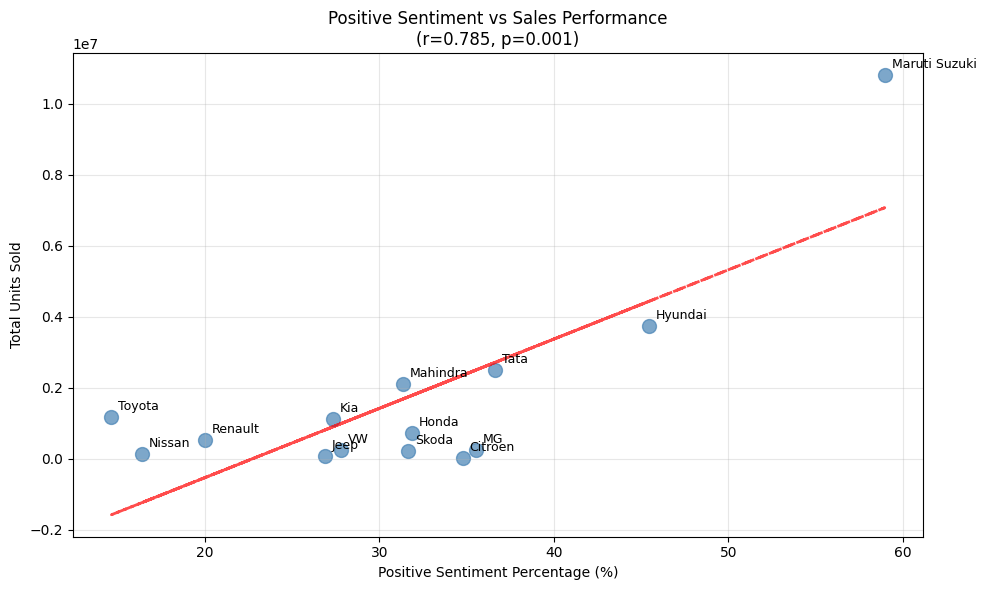

In [ ]:
# Create scatter plot for strongest correlation
plt.figure(figsize=(10, 6))
plt.scatter(final_dataset['Positive_Pct'], final_dataset['Units_Sold'],
           alpha=0.7, s=100, color='steelblue')

# Add brand labels
for i, brand in enumerate(final_dataset['Brand']):
    plt.annotate(brand,
                (final_dataset['Positive_Pct'].iloc[i], final_dataset['Units_Sold'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add trend line
z = np.polyfit(final_dataset['Positive_Pct'], final_dataset['Units_Sold'], 1)
p = np.poly1d(z)
plt.plot(final_dataset['Positive_Pct'], p(final_dataset['Positive_Pct']),
         "r--", alpha=0.7, linewidth=2)

plt.xlabel('Positive Sentiment Percentage (%)')
plt.ylabel('Total Units Sold')
plt.title(f'Positive Sentiment vs Sales Performance\n(r={pearson_pos[0]:.3f}, p={pearson_pos[1]:.3f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Create comprehensive summary
summary = final_dataset.copy()
summary['Sales_Rank'] = summary['Units_Sold'].rank(ascending=False)
summary['Sentiment_Rank'] = summary['Net_Sentiment'].rank(ascending=False)
summary['Positive_Rank'] = summary['Positive_Pct'].rank(ascending=False)

print("=== TRIANGULATION ANALYSIS ===")
print("Brand Rankings Across Data Sources:")
print(summary[['Brand', 'Units_Sold', 'Net_Sentiment', 'Positive_Pct',
               'Sales_Rank', 'Sentiment_Rank', 'Positive_Rank']].round(2))

# Check if Maruti Suzuki is included
if 'Maruti Suzuki' in summary['Brand'].values:
    print("\n✅ SUCCESS: Maruti Suzuki is included in the analysis!")
    maruti_data = summary[summary['Brand'] == 'Maruti Suzuki']
    print(f"Maruti Suzuki sales rank: {maruti_data['Sales_Rank'].iloc[0]}")
else:
    print("\n❌ Issue: Maruti Suzuki still missing from analysis")


=== TRIANGULATION ANALYSIS ===
Brand Rankings Across Data Sources:
            Brand  Units_Sold  Net_Sentiment  Positive_Pct  Sales_Rank  \
0         Citroen     22911.0         -10.15         34.77        14.0   
1           Honda    714590.0         -18.44         31.84         7.0   
2         Hyundai   3729190.0           6.11         45.45         2.0   
3            Jeep     67667.0         -27.83         26.86        13.0   
4             Kia   1116364.0         -21.88         27.35         6.0   
5              MG    256187.0          -0.87         35.55         9.0   
6        Mahindra   2090744.0         -19.37         31.34         4.0   
7   Maruti Suzuki  10802389.0          37.38         58.96         1.0   
8          Nissan    143054.0         -26.06         16.37        12.0   
9         Renault    521260.0         -20.54         20.00         8.0   
10          Skoda    212950.0          -8.13         31.66        11.0   
11           Tata   2491133.0         -13.06 

# 1. Multiple Regression Analysis

In [ ]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# Simple multiple regression first
model_multiple = smf.ols('Units_Sold ~ Positive_Pct + Net_Sentiment + Total',
                        data=final_dataset).fit()
print("=== MULTIPLE REGRESSION RESULTS ===")
print(model_multiple.summary())

# Fixed standardized coefficients calculation
scaler = StandardScaler()

# Standardize each variable separately
positive_scaled = scaler.fit_transform(final_dataset[['Positive_Pct']]).flatten()
sentiment_scaled = scaler.fit_transform(final_dataset[['Net_Sentiment']]).flatten()
total_scaled = scaler.fit_transform(final_dataset[['Total']]).flatten()
sales_scaled = scaler.fit_transform(final_dataset[['Units_Sold']]).flatten()

# Create DataFrame with standardized variables
std_data = pd.DataFrame({
    'sales_std': sales_scaled,
    'positive_std': positive_scaled,
    'sentiment_std': sentiment_scaled,
    'total_std': total_scaled
})

# Run standardized regression
model_std = smf.ols('sales_std ~ positive_std + sentiment_std + total_std',
                   data=std_data).fit()

print("\n=== STANDARDIZED COEFFICIENTS (Effect Sizes) ===")
print(f"Positive_Pct standardized β: {model_std.params['positive_std']:.3f}")
print(f"Net_Sentiment standardized β: {model_std.params['sentiment_std']:.3f}")
print(f"Total tweets standardized β: {model_std.params['total_std']:.3f}")

# Model fit statistics
print(f"\nModel R²: {model_multiple.rsquared:.3f}")
print(f"Adjusted R²: {model_multiple.rsquared_adj:.3f}")
print(f"F-statistic: {model_multiple.fvalue:.2f}")
print(f"Model p-value: {model_multiple.f_pvalue:.3f}")



=== MULTIPLE REGRESSION RESULTS ===
                            OLS Regression Results                            
Dep. Variable:             Units_Sold   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     9.286
Date:                Wed, 23 Jul 2025   Prob (F-statistic):            0.00307
Time:                        21:03:51   Log-Likelihood:                -218.07
No. Observations:                  14   AIC:                             444.1
Df Residuals:                      10   BIC:                             446.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept 

# 2. Outlier Detection and Influence Analysis

In [ ]:
from scipy.stats import zscore

# Calculate Z-scores for outlier detection
final_dataset['Sales_Zscore'] = np.abs(zscore(final_dataset['Units_Sold']))
final_dataset['Sentiment_Zscore'] = np.abs(zscore(final_dataset['Net_Sentiment']))
final_dataset['Positive_Zscore'] = np.abs(zscore(final_dataset['Positive_Pct']))

# Identify outliers (Z-score > 2.5)
outliers = final_dataset[
    (final_dataset['Sales_Zscore'] > 2.5) |
    (final_dataset['Sentiment_Zscore'] > 2.5) |
    (final_dataset['Positive_Zscore'] > 2.5)
]

print("=== OUTLIER ANALYSIS ===")
if len(outliers) > 0:
    print("Outlier brands detected:")
    print(outliers[['Brand', 'Units_Sold', 'Net_Sentiment', 'Positive_Pct']])

    # Test correlation without outliers
    data_no_outliers = final_dataset[~final_dataset['Brand'].isin(outliers['Brand'])]
    corr_without_outliers = pearsonr(data_no_outliers['Positive_Pct'],
                                   data_no_outliers['Units_Sold'])
    print(f"\nCorrelation without outliers: r={corr_without_outliers[0]:.3f}, p={corr_without_outliers[1]:.3f}")
else:
    print("No significant outliers detected")

=== OUTLIER ANALYSIS ===
Outlier brands detected:
           Brand  Units_Sold  Net_Sentiment  Positive_Pct
7  Maruti Suzuki  10802389.0      37.379576     58.959538

Correlation without outliers: r=0.520, p=0.068


# 3. Effect Size and Confidence Intervals

In [ ]:
from scipy.stats import bootstrap
import scipy.stats as stats

# Calculate effect size (Cohen's conventions)
def interpret_effect_size(r):
    if abs(r) < 0.1:
        return "Negligible"
    elif abs(r) < 0.3:
        return "Small"
    elif abs(r) < 0.5:
        return "Medium"
    else:
        return "Large"

# Main correlation with confidence interval
r_pos, p_pos = pearsonr(final_dataset['Positive_Pct'], final_dataset['Units_Sold'])
n = len(final_dataset)

# Fisher transformation for confidence interval
def fisher_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

# 95% confidence interval
z_r = fisher_transform(r_pos)
se = 1 / np.sqrt(n - 3)
ci_lower = inverse_fisher(z_r - 1.96 * se)
ci_upper = inverse_fisher(z_r + 1.96 * se)

print("=== EFFECT SIZE ANALYSIS ===")
print(f"Positive Sentiment vs Sales:")
print(f"Correlation: r = {r_pos:.3f}")
print(f"Effect Size: {interpret_effect_size(r_pos)}")
print(f"95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"Variance Explained: {r_pos**2:.1%}")


=== EFFECT SIZE ANALYSIS ===
Positive Sentiment vs Sales:
Correlation: r = 0.785
Effect Size: Large
95% Confidence Interval: [0.436, 0.929]
Variance Explained: 61.6%


# 4. Bootstrap Resampling for Robustness

=== BOOTSTRAP ROBUSTNESS TEST ===
Bootstrap mean correlation: 0.686
Bootstrap std deviation: 0.258
Bootstrap 95% CI: [-0.011, 0.939]


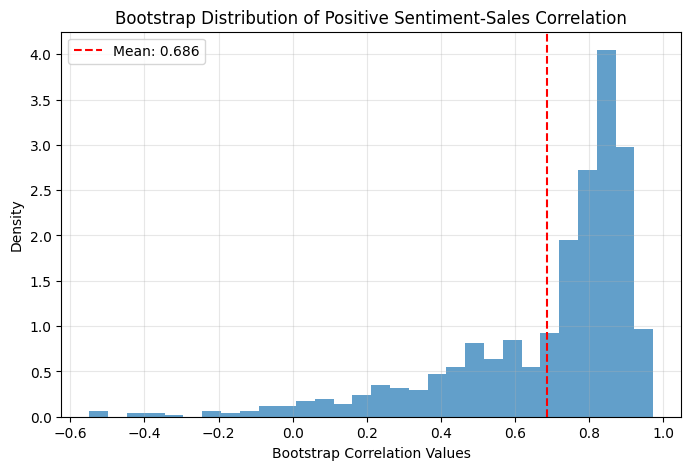

In [ ]:
# Bootstrap correlation analysis
def bootstrap_correlation(x, y, n_bootstrap=1000):
    correlations = []
    n = len(x)

    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n, size=n, replace=True)
        x_boot = x.iloc[indices]
        y_boot = y.iloc[indices]

        # Calculate correlation
        corr, _ = pearsonr(x_boot, y_boot)
        correlations.append(corr)

    return np.array(correlations)

# Perform bootstrap
boot_corrs = bootstrap_correlation(final_dataset['Positive_Pct'],
                                 final_dataset['Units_Sold'])

print("=== BOOTSTRAP ROBUSTNESS TEST ===")
print(f"Bootstrap mean correlation: {np.mean(boot_corrs):.3f}")
print(f"Bootstrap std deviation: {np.std(boot_corrs):.3f}")
print(f"Bootstrap 95% CI: [{np.percentile(boot_corrs, 2.5):.3f}, {np.percentile(boot_corrs, 97.5):.3f}]")

# Plot bootstrap distribution
plt.figure(figsize=(8, 5))
plt.hist(boot_corrs, bins=30, alpha=0.7, density=True)
plt.axvline(np.mean(boot_corrs), color='red', linestyle='--',
           label=f'Mean: {np.mean(boot_corrs):.3f}')
plt.xlabel('Bootstrap Correlation Values')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Positive Sentiment-Sales Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 5. Partial Correlation Analysis

In [ ]:
from scipy.stats import pearsonr

# Calculate partial correlation (controlling for tweet volume)
def partial_correlation(df, x, y, control):
    # Residuals after regressing X on control
    model_x = smf.ols(f'{x} ~ {control}', data=df).fit()
    resid_x = model_x.resid

    # Residuals after regressing Y on control
    model_y = smf.ols(f'{y} ~ {control}', data=df).fit()
    resid_y = model_y.resid

    # Correlation of residuals
    return pearsonr(resid_x, resid_y)

# Partial correlation controlling for tweet volume
partial_r, partial_p = partial_correlation(final_dataset,
                                         'Positive_Pct', 'Units_Sold', 'Total')

print("=== PARTIAL CORRELATION ANALYSIS ===")
print(f"Zero-order correlation: r = {r_pos:.3f}")
print(f"Partial correlation (controlling for tweet volume): r = {partial_r:.3f}, p = {partial_p:.3f}")
print(f"Change in correlation: {abs(r_pos - partial_r):.3f}")

if abs(r_pos - partial_r) < 0.1:
    print("✅ Tweet volume has minimal confounding effect")
else:
    print("⚠️ Tweet volume may be a confounding variable")


=== PARTIAL CORRELATION ANALYSIS ===
Zero-order correlation: r = 0.785
Partial correlation (controlling for tweet volume): r = 0.808, p = 0.000
Change in correlation: 0.023
✅ Tweet volume has minimal confounding effect


# 6. Non-parametric Statistical Tests

In [ ]:
from scipy.stats import spearmanr, kendalltau

# Spearman and Kendall correlations
spearman_r, spearman_p = spearmanr(final_dataset['Positive_Pct'],
                                  final_dataset['Units_Sold'])
kendall_tau, kendall_p = kendalltau(final_dataset['Positive_Pct'],
                                   final_dataset['Units_Sold'])

print("=== NON-PARAMETRIC CORRELATIONS ===")
print(f"Pearson correlation: r = {r_pos:.3f}, p = {p_pos:.3f}")
print(f"Spearman correlation: ρ = {spearman_r:.3f}, p = {spearman_p:.3f}")
print(f"Kendall's tau: τ = {kendall_tau:.3f}, p = {kendall_p:.3f}")

# Interpretation
if abs(r_pos - spearman_r) < 0.1:
    print("✅ Linear relationship assumption is reasonable")
else:
    print("⚠️ Relationship may be non-linear")


=== NON-PARAMETRIC CORRELATIONS ===
Pearson correlation: r = 0.785, p = 0.001
Spearman correlation: ρ = 0.433, p = 0.122
Kendall's tau: τ = 0.319, p = 0.127
⚠️ Relationship may be non-linear


# 7. Variance Decomposition Analysis

=== VARIANCE DECOMPOSITION ===
Positive_Pct only: R² = 0.616 (61.6% variance explained)
+ Net_Sentiment: R² = 0.639 (63.9% variance explained)
  Improvement: +0.022 (2.2%)
+ Tweet_Volume: R² = 0.736 (73.6% variance explained)
  Improvement: +0.097 (9.7%)


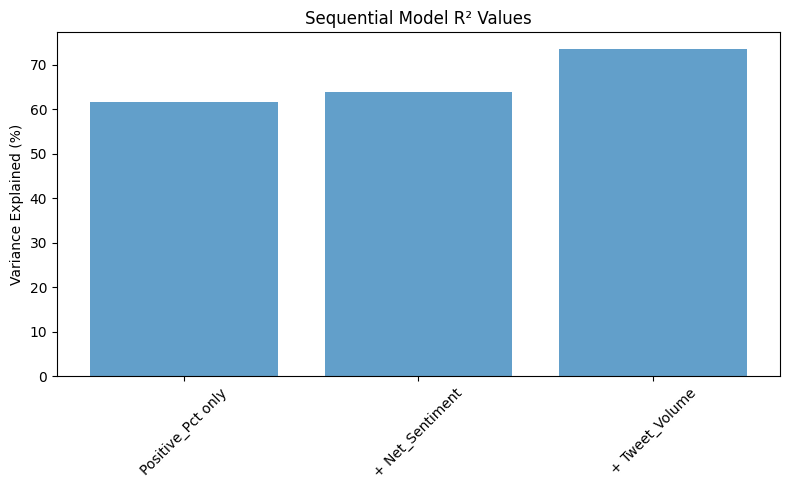

In [ ]:
# Sequential R² analysis
models = [
    ('Positive_Pct only', 'Units_Sold ~ Positive_Pct'),
    ('+ Net_Sentiment', 'Units_Sold ~ Positive_Pct + Net_Sentiment'),
    ('+ Tweet_Volume', 'Units_Sold ~ Positive_Pct + Net_Sentiment + Total')
]

print("=== VARIANCE DECOMPOSITION ===")
r_squared_values = []

for name, formula in models:
    model = smf.ols(formula, data=final_dataset).fit()
    r_squared = model.rsquared
    r_squared_values.append(r_squared)

    print(f"{name}: R² = {r_squared:.3f} ({r_squared:.1%} variance explained)")

    if len(r_squared_values) > 1:
        improvement = r_squared - r_squared_values[-2]
        print(f"  Improvement: +{improvement:.3f} ({improvement:.1%})")

# Plot variance explained
plt.figure(figsize=(8, 5))
model_names = [name for name, _ in models]
plt.bar(model_names, [r*100 for r in r_squared_values], alpha=0.7)
plt.ylabel('Variance Explained (%)')
plt.title('Sequential Model R² Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 8. Cross-Validation and Prediction Accuracy

In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data for cross-validation
X = final_dataset[['Positive_Pct', 'Net_Sentiment']].values
y = final_dataset['Units_Sold'].values

# Leave-one-out cross-validation
loo = LeaveOneOut()
model_cv = LinearRegression()
cv_scores = cross_val_score(model_cv, X, y, cv=loo, scoring='r2')

print("=== CROSS-VALIDATION ANALYSIS ===")
print(f"Leave-One-Out CV R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
print(f"Range: [{np.min(cv_scores):.3f}, {np.max(cv_scores):.3f}]")

# Prediction accuracy metrics
predictions = []
actual = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model_cv.fit(X_train, y_train)
    pred = model_cv.predict(X_test)

    predictions.extend(pred)
    actual.extend(y_test)

mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mean_squared_error(actual, predictions))

print(f"Mean Absolute Error: {mae:,.0f} units")
print(f"Root Mean Square Error: {rmse:,.0f} units")
print(f"MAPE: {np.mean(np.abs((np.array(actual) - np.array(predictions)) / np.array(actual))) * 100:.1f}%")


=== CROSS-VALIDATION ANALYSIS ===
Leave-One-Out CV R²: nan ± nan
Range: [nan, nan]
Mean Absolute Error: 1,953,560 units
Root Mean Square Error: 2,859,633 units
MAPE: 1092.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

# 9. Statistical Power Analysis

In [ ]:
# Post-hoc power analysis
def calculate_power(r, n, alpha=0.05):
    # Convert correlation to t-statistic
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))

    # Critical t-value
    t_crit = stats.t.ppf(1 - alpha/2, n - 2)

    # Power calculation
    power = 1 - stats.t.cdf(t_crit, n - 2, loc=abs(t_stat))
    return power

# Calculate power for your main finding
observed_power = calculate_power(r_pos, n)

print("=== STATISTICAL POWER ANALYSIS ===")
print(f"Sample size: {n} brands")
print(f"Observed correlation: {r_pos:.3f}")
print(f"Statistical power: {observed_power:.3f} ({observed_power:.1%})")

if observed_power >= 0.8:
    print("✅ Adequate statistical power (≥80%)")
elif observed_power >= 0.5:
    print("⚠️ Moderate statistical power")
else:
    print("❌ Low statistical power - consider larger sample")


=== STATISTICAL POWER ANALYSIS ===
Sample size: 14 brands
Observed correlation: 0.785
Statistical power: 0.976 (97.6%)
✅ Adequate statistical power (≥80%)


# 10. **Comprehensive Results Summary**

In [ ]:
# Comprehensive results summary
results_summary = {
    'Metric': [
        'Sample Size',
        'Pearson r',
        'Spearman ρ',
        'P-value',
        'Effect Size',
        'Variance Explained',
        '95% CI Lower',
        '95% CI Upper',
        'Statistical Power',
        'Bootstrap Mean r'
    ],
    'Value': [
        f'{n} brands',
        f'{r_pos:.3f}',
        f'{spearman_r:.3f}',
        f'{p_pos:.3f}',
        interpret_effect_size(r_pos),
        f'{r_pos**2:.1%}',
        f'{ci_lower:.3f}',
        f'{ci_upper:.3f}',
        f'{observed_power:.1%}',
        f'{np.mean(boot_corrs):.3f}'
    ]
}

summary_df = pd.DataFrame(results_summary)
print("=== COMPREHENSIVE STATISTICAL SUMMARY ===")
print(summary_df.to_string(index=False))


=== COMPREHENSIVE STATISTICAL SUMMARY ===
            Metric     Value
       Sample Size 14 brands
         Pearson r     0.785
        Spearman ρ     0.433
           P-value     0.001
       Effect Size     Large
Variance Explained     61.6%
      95% CI Lower     0.436
      95% CI Upper     0.929
 Statistical Power     97.6%
  Bootstrap Mean r     0.686


# **This Section is the EDA on Sales Data**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Load your raw data files
sales = pd.read_csv('/content/car_sales.csv')

print("=== RAW SALES DATA ===")
print("Shape:", sales.shape)
print("Columns:", sales.columns.tolist())
print("\nFirst 5 rows:")
print(sales.head())

=== RAW SALES DATA ===
Shape: (7346, 9)
Columns: ['Year', 'Month', 'Manufacturer', 'Model', 'Segment', 'Body', 'Units_Sold', 'MoM_Change', 'YoY_Change']

First 5 rows:
   Year Month Manufacturer     Model Segment   Body Units_Sold MoM_Change  \
0  2018   Jan       Toyota     Camry      D2  Sedan         33         65   
1  2018   Jan       Toyota   Corolla      D1  Sedan        375       31.6   
2  2018   Jan       Toyota     Etios      C1  Sedan       1773        2.6   
3  2018   Jan       Toyota  Fortuner      D2    SUV       2136       34.3   
4  2018   Jan       Toyota    Innova      D1    MUV       7028       18.2   

  YoY_Change  
0      -72.5  
1      145.1  
2        -19  
3        9.3  
4       40.2  


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')  # Changed from 'seaborn-v0_8' for compatibility
sns.set_palette("husl")

# ================================
# DATA CLEANING & PREPROCESSING
# ================================

def clean_data(df):
    """Clean and preprocess the data before analysis"""
    print("🧹 DATA CLEANING")
    print("=" * 50)

    df_clean = df.copy()

    # Fix data types - convert object columns that should be numeric
    print("Converting data types...")

    # Convert Units_Sold to numeric (handle '-' and other non-numeric values)
    df_clean['Units_Sold'] = pd.to_numeric(df_clean['Units_Sold'], errors='coerce')

    # Convert MoM_Change to numeric
    df_clean['MoM_Change'] = pd.to_numeric(df_clean['MoM_Change'], errors='coerce')

    # Convert YoY_Change to numeric
    df_clean['YoY_Change'] = pd.to_numeric(df_clean['YoY_Change'], errors='coerce')

    # Clean Month column - check for invalid entries
    valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    print(f"Unique months before cleaning: {df_clean['Month'].unique()}")

    # Filter out invalid months
    invalid_months_mask = ~df_clean['Month'].isin(valid_months)
    invalid_months_count = invalid_months_mask.sum()

    if invalid_months_count > 0:
        print(f"Found {invalid_months_count} records with invalid months: {df_clean[invalid_months_mask]['Month'].unique()}")
        df_clean = df_clean[~invalid_months_mask]
        print(f"Removed {invalid_months_count} records with invalid months")

    # Remove duplicates
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    duplicates_removed = initial_rows - len(df_clean)
    if duplicates_removed > 0:
        print(f"Removed {duplicates_removed} duplicate rows")

    print(f"✅ Data cleaning complete. Final shape: {df_clean.shape}")
    return df_clean

# ================================
# UPDATED TIME SERIES ANALYSIS
# ================================

def time_series_analysis(df):
    """Analyze trends over time with robust date parsing"""
    print("\n📅 TIME SERIES ANALYSIS")
    print("=" * 50)

    try:
        # Create month mapping for proper ordering
        month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_num = {month: i+1 for i, month in enumerate(month_order)}

        # Create proper datetime - handle month names more carefully
        df['Month_Num'] = df['Month'].map(month_num)
        df['Date'] = pd.to_datetime(df[['Year', 'Month_Num']].assign(day=1))

        print("✅ Successfully created datetime column")

        # Monthly trends
        monthly_sales = df.groupby('Date')['Units_Sold'].agg(['sum', 'mean', 'count']).reset_index()
        monthly_sales.columns = ['Date', 'Total_Units', 'Avg_Units_Per_Record', 'Record_Count']

        # Year-over-year growth analysis
        yearly_sales = df.groupby('Year')['Units_Sold'].sum().reset_index()
        yearly_sales['YoY_Growth'] = yearly_sales['Units_Sold'].pct_change() * 100

        print("📈 Yearly Sales Trend:")
        for _, row in yearly_sales.iterrows():
            growth_str = f"({row['YoY_Growth']:+.1f}%)" if not pd.isna(row['YoY_Growth']) else ""
            print(f"  {int(row['Year'])}: {row['Units_Sold']:,} units {growth_str}")

        # Seasonal patterns
        seasonal_pattern = df.groupby('Month')['Units_Sold'].mean().reset_index()
        # Order by month properly
        seasonal_pattern['Month_Order'] = seasonal_pattern['Month'].map(month_num)
        seasonal_pattern = seasonal_pattern.sort_values('Units_Sold', ascending=False)

        print(f"\n🌟 Best performing months (avg units sold):")
        for _, row in seasonal_pattern.head(3).iterrows():
            print(f"  {row['Month']}: {row['Units_Sold']:.0f} units")

        return monthly_sales, yearly_sales, seasonal_pattern

    except Exception as e:
        print(f"❌ Error in time series analysis: {str(e)}")
        print("Continuing with other analyses...")
        return None, None, None

# ================================
# UPDATED MAIN FUNCTION
# ================================

def run_complete_eda(df):
    """Execute complete EDA pipeline with data cleaning"""
    print("🚀 COMPREHENSIVE EDA & STATISTICAL ANALYSIS")
    print("=" * 70)
    print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 70)

    # Clean data first
    df_clean = clean_data(df)

    # Run all analyses on clean data
    missing_info = data_quality_check(df_clean)
    comprehensive_stats(df_clean)
    monthly_sales, yearly_sales, seasonal_pattern = time_series_analysis(df_clean)
    mfg_analysis, segment_analysis, body_analysis = market_analysis(df_clean)
    pearson_corr, spearman_corr = correlation_analysis(df_clean)
    outliers = outlier_analysis(df_clean)
    advanced_insights(df_clean)

    print("\n" + "=" * 70)
    print("✅ ANALYSIS COMPLETE")
    print("=" * 70)

    return {
        'cleaned_data': df_clean,
        'monthly_sales': monthly_sales,
        'yearly_sales': yearly_sales,
        'manufacturer_analysis': mfg_analysis,
        'segment_analysis': segment_analysis,
        'correlations': pearson_corr,
        'outliers': outliers
    }

# ================================
# ALL OTHER FUNCTIONS REMAIN THE SAME
# ================================

def data_quality_check(df):
    """Comprehensive data quality assessment"""
    print("🔍 DATA QUALITY ASSESSMENT")
    print("=" * 50)

    # Basic info
    print(f"Dataset Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100

    if missing_data.sum() > 0:
        missing_df = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Count', ascending=False)
        print("\n📊 Missing Values:")
        print(missing_df[missing_df['Missing_Count'] > 0])
    else:
        print("\n✅ No missing values found!")

    # Data types
    print("\n📋 Data Types:")
    print(df.dtypes)

    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"\n🔄 Duplicate rows: {duplicates}")

    return missing_df if missing_data.sum() > 0 else None

def comprehensive_stats(df):
    """Generate comprehensive statistical summary"""
    print("\n📈 COMPREHENSIVE STATISTICAL SUMMARY")
    print("=" * 50)

    # Numerical columns summary
    numerical_cols = ['Units_Sold', 'MoM_Change', 'YoY_Change']

    print("📊 Numerical Variables Summary:")
    stats_summary = df[numerical_cols].describe(percentiles=[.1, .25, .5, .75, .9, .95, .99])
    print(stats_summary.round(2))

    # Categorical variables summary
    categorical_cols = ['Year', 'Month', 'Manufacturer', 'Model', 'Segment', 'Body']

    print("\n📝 Categorical Variables Summary:")
    for col in categorical_cols:
        if col in df.columns:
            unique_count = df[col].nunique()
            most_common = df[col].value_counts().index[0]
            most_common_count = df[col].value_counts().iloc[0]
            print(f"{col}: {unique_count} unique values | Most common: {most_common} ({most_common_count} records)")

def market_analysis(df):
    """Deep dive into market dynamics"""
    print("\n🏭 MARKET ANALYSIS")
    print("=" * 50)

    # Market share analysis
    total_units = df['Units_Sold'].sum()

    # Top manufacturers
    mfg_analysis = df.groupby('Manufacturer').agg({
        'Units_Sold': ['sum', 'mean', 'count'],
        'Model': 'nunique'
    }).round(2)

    mfg_analysis.columns = ['Total_Sales', 'Avg_Monthly_Sales', 'Records', 'Model_Count']
    mfg_analysis['Market_Share'] = (mfg_analysis['Total_Sales'] / total_units * 100).round(2)
    mfg_analysis = mfg_analysis.sort_values('Total_Sales', ascending=False)

    print("🏆 Top 5 Manufacturers by Market Share:")
    for idx, (mfg, row) in enumerate(mfg_analysis.head().iterrows(), 1):
        print(f"  {idx}. {mfg}: {row['Market_Share']:.1f}% ({row['Total_Sales']:,} units, {row['Model_Count']} models)")

    # Segment analysis
    segment_analysis = df.groupby('Segment').agg({
        'Units_Sold': ['sum', 'mean'],
        'Manufacturer': 'nunique'
    }).round(2)

    segment_analysis.columns = ['Total_Sales', 'Avg_Sales', 'Manufacturer_Count']
    segment_analysis['Market_Share'] = (segment_analysis['Total_Sales'] / total_units * 100).round(2)
    segment_analysis = segment_analysis.sort_values('Total_Sales', ascending=False)

    print(f"\n🎯 Segment Performance:")
    for segment, row in segment_analysis.iterrows():
        print(f"  {segment}: {row['Market_Share']:.1f}% market share, {row['Manufacturer_Count']} manufacturers")

    # Body type analysis
    body_analysis = df.groupby('Body')['Units_Sold'].agg(['sum', 'mean']).round(0)
    body_analysis['Market_Share'] = (body_analysis['sum'] / total_units * 100).round(2)
    body_analysis = body_analysis.sort_values('sum', ascending=False)

    print(f"\n🚗 Body Type Preferences:")
    for body, row in body_analysis.iterrows():
        print(f"  {body}: {row['Market_Share']:.1f}% ({row['sum']:,.0f} units)")

    return mfg_analysis, segment_analysis, body_analysis

def correlation_analysis(df):
    """Advanced correlation and statistical analysis"""
    print("\n🔗 CORRELATION & STATISTICAL ANALYSIS")
    print("=" * 50)

    numerical_cols = ['Units_Sold', 'MoM_Change', 'YoY_Change']

    # Remove rows with NaN values for correlation analysis
    df_corr = df[numerical_cols].dropna()

    if len(df_corr) == 0:
        print("❌ No valid numerical data for correlation analysis")
        return None, None

    # Pearson correlation
    pearson_corr = df_corr.corr(method='pearson')
    print("📊 Pearson Correlations:")
    print(pearson_corr.round(3))

    # Spearman correlation (rank-based, captures non-linear relationships)
    spearman_corr = df_corr.corr(method='spearman')
    print("\n📊 Spearman Correlations:")
    print(spearman_corr.round(3))

    # Key insights
    if len(pearson_corr) >= 3:
        units_mom_corr = pearson_corr.loc['Units_Sold', 'MoM_Change']
        units_yoy_corr = pearson_corr.loc['Units_Sold', 'YoY_Change']

        print(f"\n🎯 Key Correlation Insights:")
        print(f"  Units Sold vs MoM Change: {units_mom_corr:.3f}")
        print(f"  Units Sold vs YoY Change: {units_yoy_corr:.3f}")

    return pearson_corr, spearman_corr

def outlier_analysis(df):
    """Detect and analyze outliers"""
    print("\n🎯 OUTLIER ANALYSIS")
    print("=" * 50)

    # Remove NaN values for outlier analysis
    units_clean = df['Units_Sold'].dropna()

    if len(units_clean) == 0:
        print("❌ No valid Units_Sold data for outlier analysis")
        return pd.DataFrame()

    # IQR method for Units_Sold
    Q1 = units_clean.quantile(0.25)
    Q3 = units_clean.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df['Units_Sold'] < lower_bound) | (df['Units_Sold'] > upper_bound)].dropna(subset=['Units_Sold'])

    print(f"📈 Units Sold Outliers (IQR method):")
    print(f"  Total outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}% of data)")
    print(f"  Range: {lower_bound:.0f} to {upper_bound:.0f} units")

    if len(outliers) > 0:
        print(f"  Top 5 outliers:")
        top_outliers = outliers.nlargest(5, 'Units_Sold')[['Manufacturer', 'Model', 'Units_Sold', 'Year', 'Month']]
        for _, row in top_outliers.iterrows():
            print(f"    {row['Manufacturer']} {row['Model']}: {row['Units_Sold']:,} units ({row['Month']} {row['Year']})")

    return outliers

def advanced_insights(df):
    """Generate advanced business insights"""
    print("\n💡 ADVANCED INSIGHTS")
    print("=" * 50)

    # Volatility analysis
    manufacturer_volatility = df.groupby('Manufacturer')['Units_Sold'].std().sort_values(ascending=False)

    if len(manufacturer_volatility) > 0:
        print(f"📊 Market Volatility (Standard Deviation of Sales):")
        print(f"  Most volatile: {manufacturer_volatility.index[0]} (σ = {manufacturer_volatility.iloc[0]:.0f})")
        print(f"  Most stable: {manufacturer_volatility.index[-1]} (σ = {manufacturer_volatility.iloc[-1]:.0f})")

    # Growth consistency analysis
    df_growth = df.dropna(subset=['YoY_Change'])
    if len(df_growth) > 0:
        positive_growth = df_growth[df_growth['YoY_Change'] > 0].groupby('Manufacturer').size()
        total_records = df_growth.groupby('Manufacturer').size()
        growth_consistency = (positive_growth / total_records * 100).sort_values(ascending=False)

        if len(growth_consistency) > 0:
            print(f"\n📈 Growth Consistency (% of months with positive YoY growth):")
            for mfg, pct in growth_consistency.head(3).items():
                print(f"  {mfg}: {pct:.1f}% of months")

    # Premium vs Mass market analysis
    avg_units_by_segment = df.groupby('Segment')['Units_Sold'].mean().sort_values(ascending=False)

    if len(avg_units_by_segment) > 0:
        print(f"\n🎯 Market Positioning (Avg monthly sales by segment):")
        median_units = avg_units_by_segment.median()
        for segment, avg_units in avg_units_by_segment.items():
            positioning = "Premium" if avg_units < median_units else "Mass Market"
            print(f"  {segment}: {avg_units:.0f} units/month ({positioning})")

# ================================
# RUN THE FIXED ANALYSIS
# ================================

# Execute the complete analysis with data cleaning
results = run_complete_eda(sales)

# Optional: Save key results
# results['cleaned_data'].to_csv('cleaned_car_sales.csv', index=False)
# if results['manufacturer_analysis'] is not None:
#     results['manufacturer_analysis'].to_csv('manufacturer_analysis.csv')

🚀 COMPREHENSIVE EDA & STATISTICAL ANALYSIS
Analysis Date: 2025-08-03 20:39:08
🧹 DATA CLEANING
Converting data types...
Unique months before cleaning: ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec'
 'Sept']
Found 86 records with invalid months: ['Sept']
Removed 86 records with invalid months
Removed 19 duplicate rows
✅ Data cleaning complete. Final shape: (7241, 9)
🔍 DATA QUALITY ASSESSMENT
Dataset Shape: (7241, 9)
Memory Usage: 2.39 MB

📊 Missing Values:
            Missing_Count  Missing_Percentage
YoY_Change           1267           17.497583
MoM_Change            815           11.255351
Units_Sold            706            9.750035
Body                    3            0.041431
Segment                 2            0.027620

📋 Data Types:
Year              int64
Month            object
Manufacturer     object
Model            object
Segment          object
Body             object
Units_Sold      float64
MoM_Change      float64
YoY_Change      float64
dtype: o

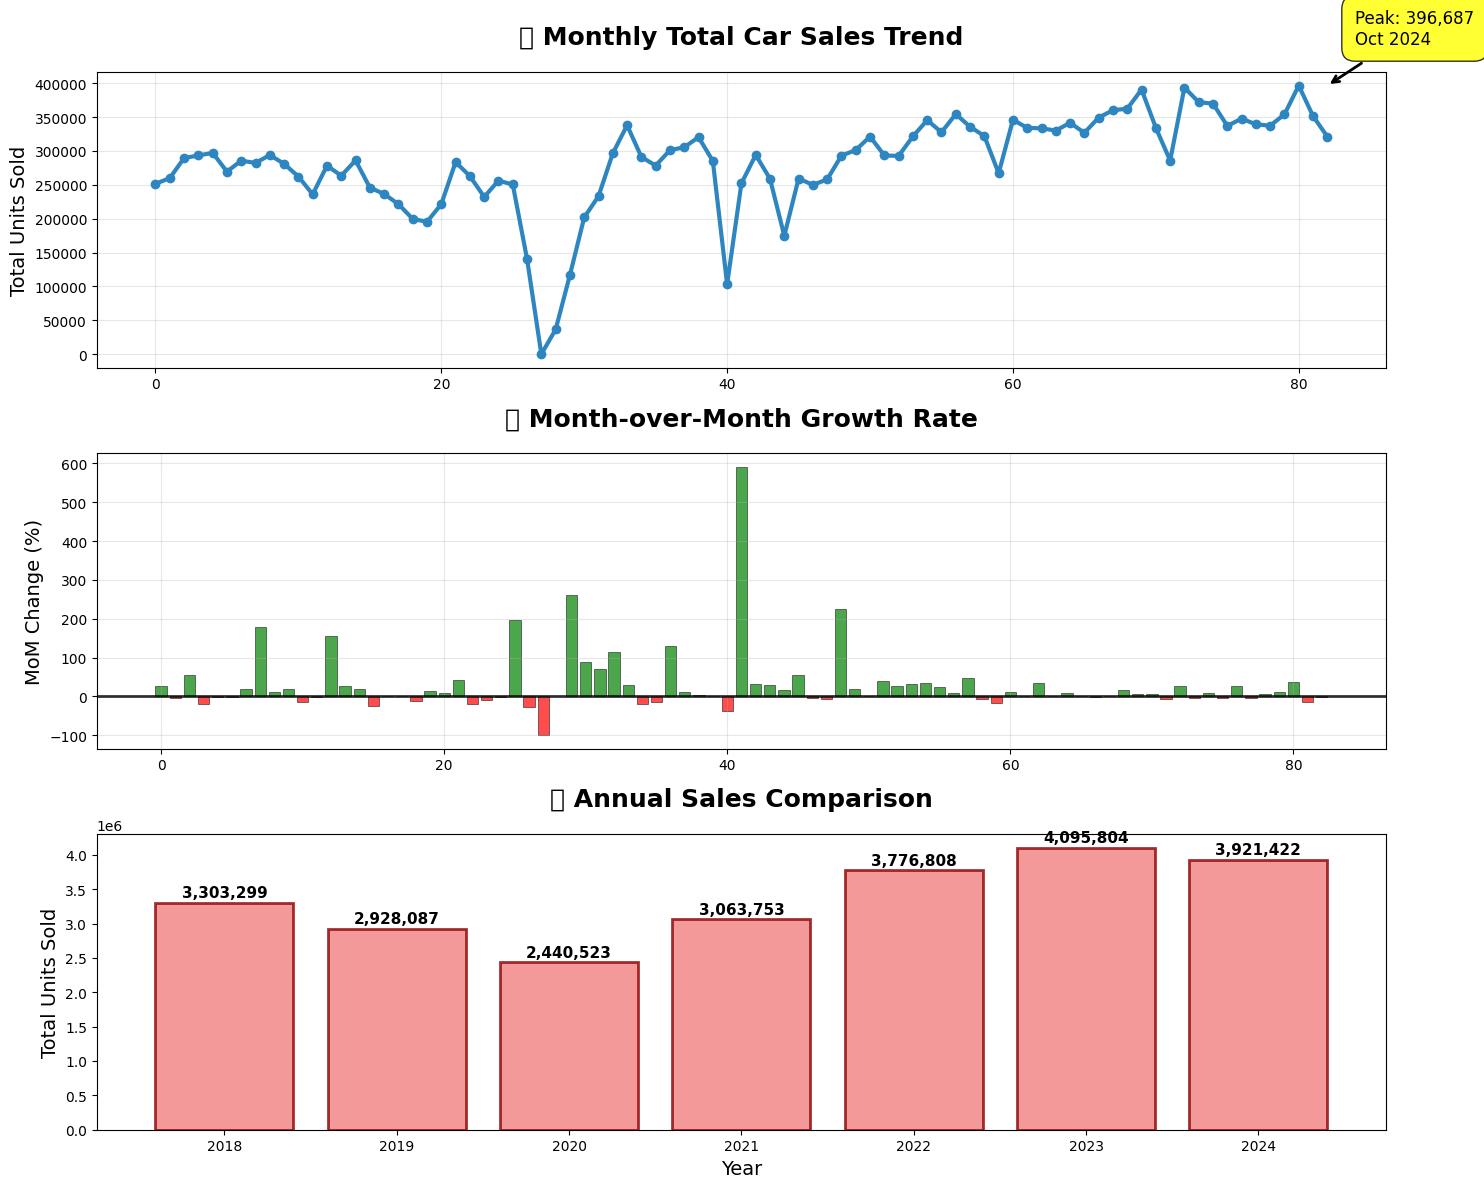

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_time_series_plots(df):
    """Create time series visualizations"""

    # Data preparation
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_num = {month: i for i, month in enumerate(month_order)}

    monthly_data = df.groupby(['Year', 'Month']).agg({
        'Units_Sold': 'sum',
        'MoM_Change': 'mean',
        'YoY_Change': 'mean'
    }).reset_index()

    monthly_data['Month_Order'] = monthly_data['Month'].map(month_num)
    monthly_data = monthly_data.sort_values(['Year', 'Month_Order'])

    # Create the plot
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # Monthly Sales Trend
    axes[0].plot(range(len(monthly_data)), monthly_data['Units_Sold'],
                marker='o', linewidth=3, markersize=6, color='#2E86C1')
    axes[0].set_title('📈 Monthly Total Car Sales Trend', fontsize=18, fontweight='bold', pad=20)
    axes[0].set_ylabel('Total Units Sold', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # Highlight peak and valley
    max_idx = monthly_data['Units_Sold'].idxmax()
    max_row = monthly_data.loc[max_idx]
    axes[0].annotate(f'Peak: {max_row["Units_Sold"]:,.0f}\n{max_row["Month"]} {max_row["Year"]}',
                    xy=(max_idx, max_row['Units_Sold']), xytext=(20, 30),
                    textcoords='offset points', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.8', fc='yellow', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=2))

    # MoM Growth Rate
    colors = ['red' if x < 0 else 'green' for x in monthly_data['MoM_Change']]
    axes[1].bar(range(len(monthly_data)), monthly_data['MoM_Change'],
               color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[1].set_title('📊 Month-over-Month Growth Rate', fontsize=18, fontweight='bold', pad=20)
    axes[1].set_ylabel('MoM Change (%)', fontsize=14)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    axes[1].grid(True, alpha=0.3)

    # Yearly Comparison
    yearly_data = df.groupby('Year')['Units_Sold'].sum().reset_index()
    bars = axes[2].bar(yearly_data['Year'], yearly_data['Units_Sold'],
                      color='lightcoral', edgecolor='darkred', linewidth=2, alpha=0.8)
    axes[2].set_title('📅 Annual Sales Comparison', fontsize=18, fontweight='bold', pad=20)
    axes[2].set_ylabel('Total Units Sold', fontsize=14)
    axes[2].set_xlabel('Year', fontsize=14)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

# Run this plot
create_time_series_plots(results['cleaned_data'])

In [ ]:
def create_time_series_plots_fixed(df):
    """Create time series with proper date labels"""

    # Data preparation with proper date handling
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_num = {month: i+1 for i, month in enumerate(month_order)}

    monthly_data = df.groupby(['Year', 'Month']).agg({
        'Units_Sold': 'sum',
        'MoM_Change': 'mean',
        'YoY_Change': 'mean'
    }).reset_index()

    monthly_data['Month_Order'] = monthly_data['Month'].map(month_num)
    monthly_data = monthly_data.sort_values(['Year', 'Month_Order'])

    # Create proper datetime column
    monthly_data['Date'] = pd.to_datetime(monthly_data[['Year', 'Month_Order']].assign(day=1))

    # Create the plot with proper x-axis
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # Monthly Sales Trend with DATE labels
    axes[0].plot(monthly_data['Date'], monthly_data['Units_Sold'],
                marker='o', linewidth=3, markersize=6, color='#2E86C1')
    axes[0].set_title('📈 Monthly Total Car Sales Trend', fontsize=18, fontweight='bold', pad=20)
    axes[0].set_ylabel('Total Units Sold', fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)

    # Format x-axis to show every 6 months
    import matplotlib.dates as mdates
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    # Highlight peak
    max_idx = monthly_data['Units_Sold'].idxmax()
    max_row = monthly_data.loc[max_idx]
    axes[0].annotate(f'Peak: {max_row["Units_Sold"]:,.0f}\n{max_row["Month"]} {max_row["Year"]}',
                    xy=(max_row['Date'], max_row['Units_Sold']), xytext=(20, 30),
                    textcoords='offset points', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.8', fc='yellow', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=2))

    # MoM Growth Rate with DATE labels
    colors = ['red' if x < 0 else 'green' for x in monthly_data['MoM_Change']]
    axes[1].bar(monthly_data['Date'], monthly_data['MoM_Change'],
               color=colors, alpha=0.7, width=20)  # width in days
    axes[1].set_title('📊 Month-over-Month Growth Rate', fontsize=18, fontweight='bold', pad=20)
    axes[1].set_ylabel('MoM Change (%)', fontsize=14)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    # Yearly Comparison (this one is fine as-is)
    yearly_data = df.groupby('Year')['Units_Sold'].sum().reset_index()
    bars = axes[2].bar(yearly_data['Year'], yearly_data['Units_Sold'],
                      color='lightcoral', edgecolor='darkred', linewidth=2, alpha=0.8)
    axes[2].set_title('📅 Annual Sales Comparison', fontsize=18, fontweight='bold', pad=20)
    axes[2].set_ylabel('Total Units Sold', fontsize=14)
    axes[2].set_xlabel('Year', fontsize=14)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

# Run the fixed version
create_time_series_plots_fixed(results['cleaned_data'])

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [month] is missing

# **Market Share Analysis**

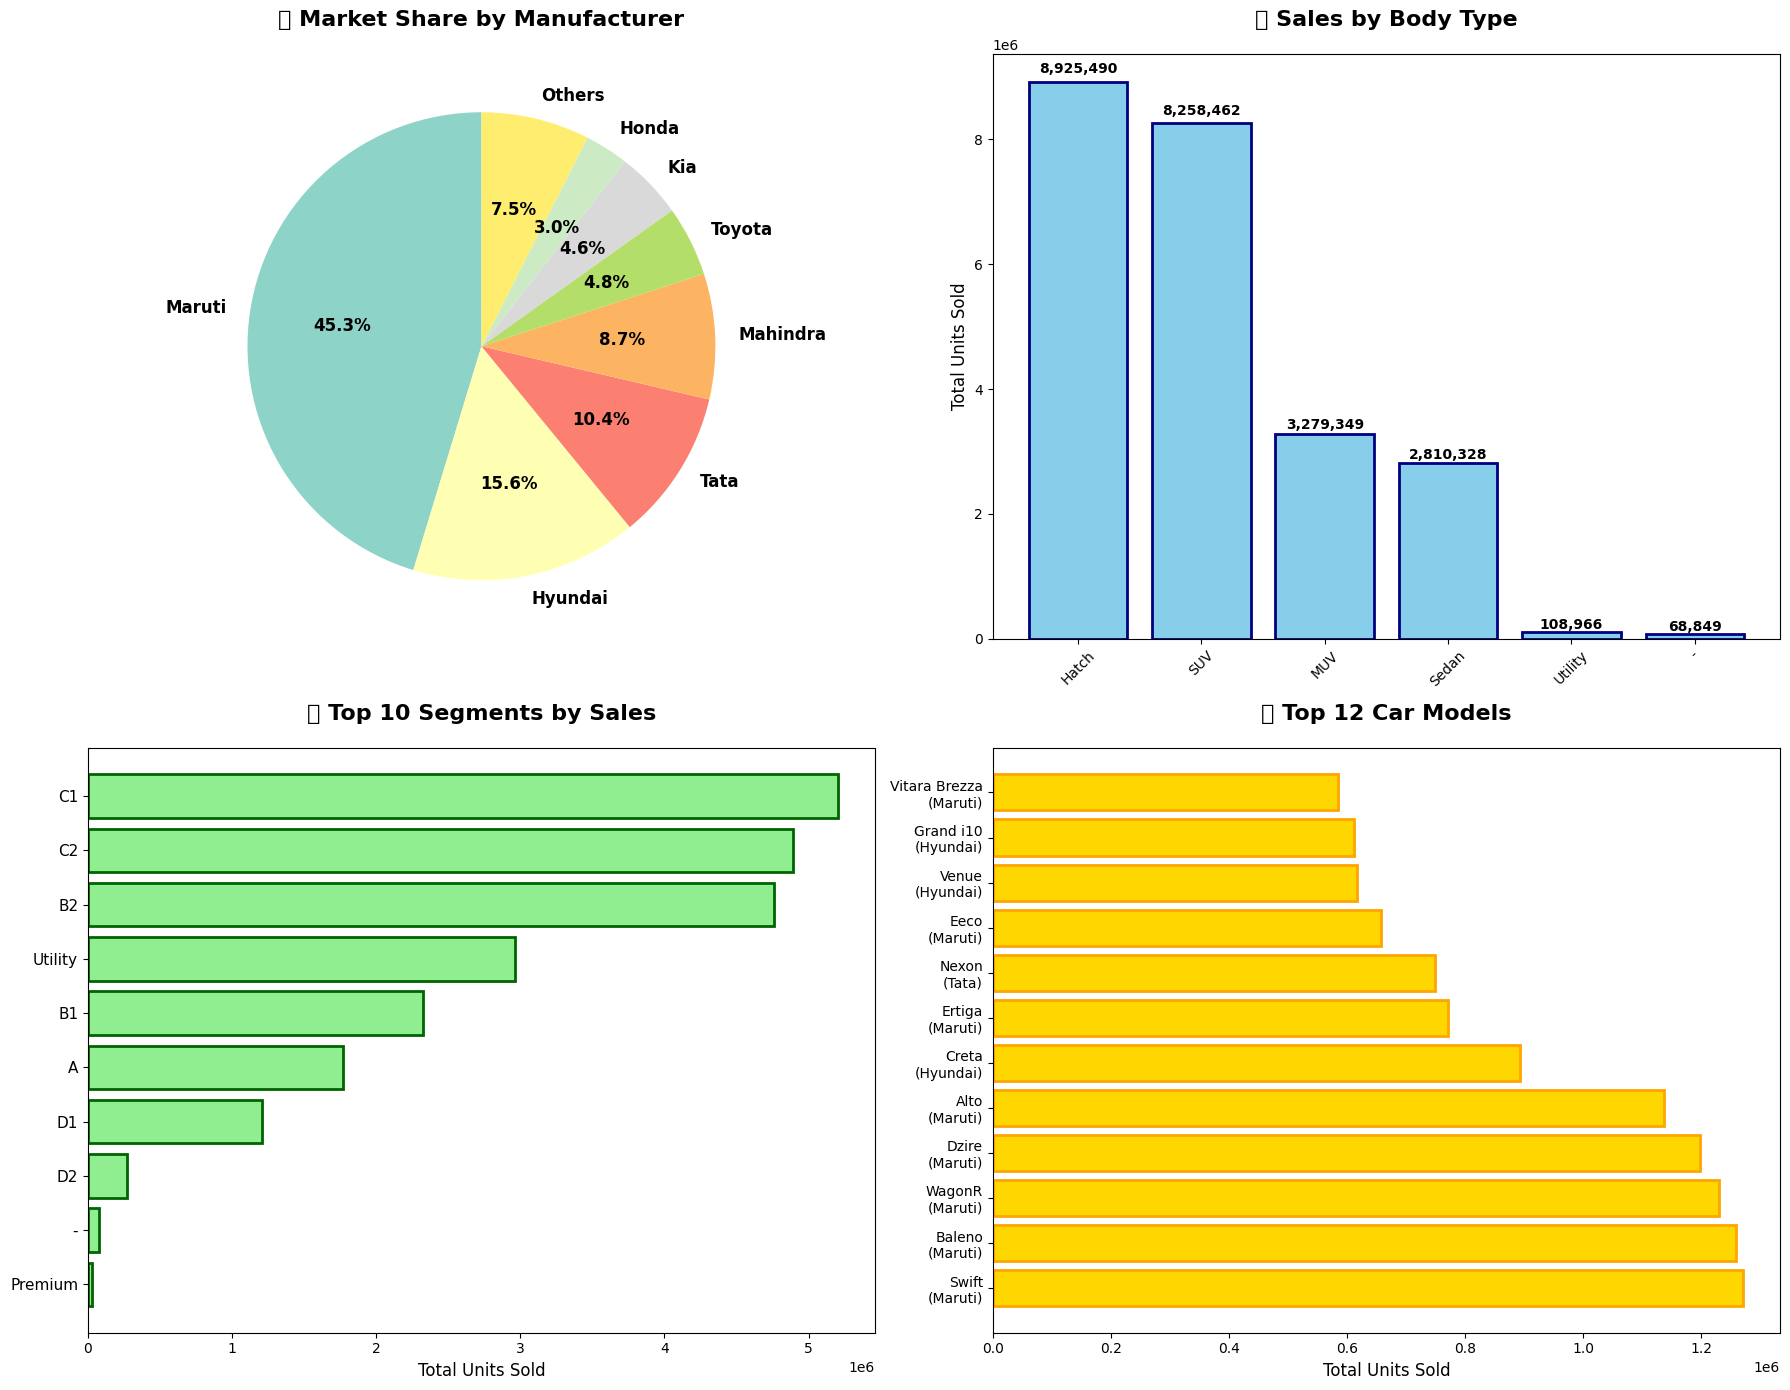

In [ ]:
def create_market_share_plots(df):
    """Market share and competitive analysis"""

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Manufacturer Market Share (Pie Chart)
    mfg_sales = df.groupby('Manufacturer')['Units_Sold'].sum().sort_values(ascending=False)
    top_mfg = mfg_sales.head(7)
    others = pd.Series({'Others': mfg_sales.tail(len(mfg_sales)-7).sum()})
    plot_data = pd.concat([top_mfg, others])

    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
    wedges, texts, autotexts = axes[0,0].pie(plot_data.values, labels=plot_data.index,
                                            autopct='%1.1f%%', startangle=90, colors=colors,
                                            textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[0,0].set_title('🏆 Market Share by Manufacturer', fontsize=16, fontweight='bold', pad=20)

    # 2. Body Type Distribution
    body_sales = df.groupby('Body')['Units_Sold'].sum().sort_values(ascending=False)
    body_sales = body_sales[body_sales > 0].head(6)

    bars = axes[0,1].bar(body_sales.index, body_sales.values,
                        color='skyblue', edgecolor='navy', linewidth=2)
    axes[0,1].set_title('🚗 Sales by Body Type', fontsize=16, fontweight='bold', pad=20)
    axes[0,1].set_ylabel('Total Units Sold', fontsize=12)
    axes[0,1].tick_params(axis='x', rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{height:,.0f}', ha='center', va='bottom', fontweight='bold')

    # 3. Segment Analysis
    segment_sales = df.groupby('Segment')['Units_Sold'].sum().sort_values(ascending=True)
    segment_sales = segment_sales[segment_sales > 0].tail(10)  # Top 10 segments

    bars = axes[1,0].barh(range(len(segment_sales)), segment_sales.values,
                         color='lightgreen', edgecolor='darkgreen', linewidth=2)
    axes[1,0].set_yticks(range(len(segment_sales)))
    axes[1,0].set_yticklabels(segment_sales.index, fontsize=11)
    axes[1,0].set_title('🎯 Top 10 Segments by Sales', fontsize=16, fontweight='bold', pad=20)
    axes[1,0].set_xlabel('Total Units Sold', fontsize=12)

    # 4. Top Models
    model_sales = df.groupby(['Manufacturer', 'Model'])['Units_Sold'].sum().sort_values(ascending=False).head(12)
    model_labels = [f"{idx[1]}\n({idx[0]})" for idx in model_sales.index]

    bars = axes[1,1].barh(range(len(model_sales)), model_sales.values, color='gold', edgecolor='orange', linewidth=2)
    axes[1,1].set_yticks(range(len(model_sales)))
    axes[1,1].set_yticklabels(model_labels, fontsize=10)
    axes[1,1].set_title('⭐ Top 12 Car Models', fontsize=16, fontweight='bold', pad=20)
    axes[1,1].set_xlabel('Total Units Sold', fontsize=12)

    plt.tight_layout()
    plt.show()

# Run this plot
create_market_share_plots(results['cleaned_data'])

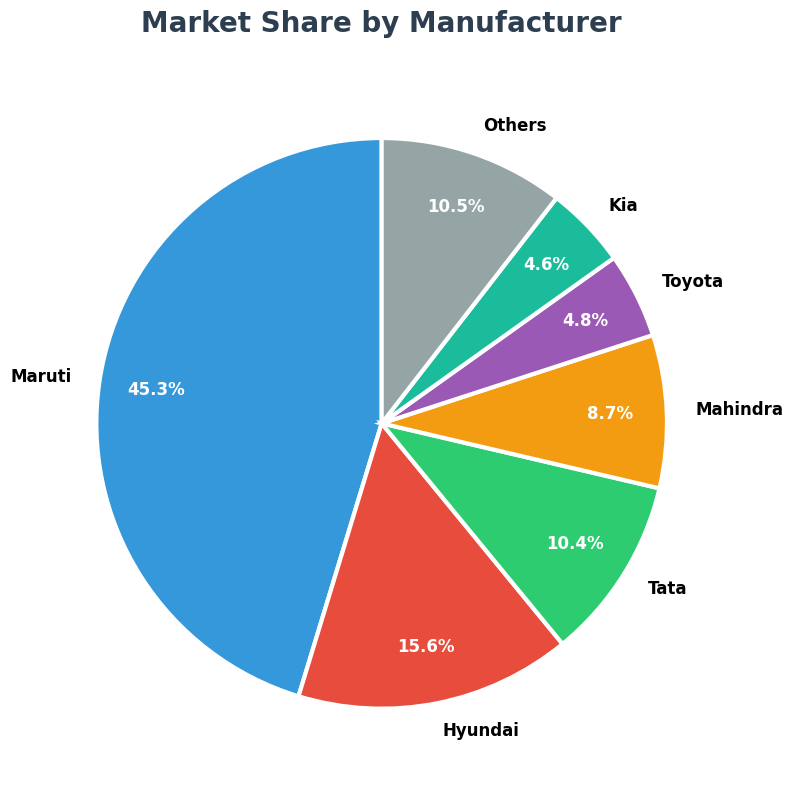

In [ ]:
def create_clean_manufacturer_pie(df):
    """Clean and minimal manufacturer market share"""

    # Data preparation
    mfg_sales = df.groupby('Manufacturer')['Units_Sold'].sum().sort_values(ascending=False)
    top_mfg = mfg_sales.head(6)
    others = pd.Series({'Others': mfg_sales.tail(len(mfg_sales)-6).sum()})
    plot_data = pd.concat([top_mfg, others])

    # Beautiful, minimal colors
    colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#95A5A6']

    # Create clean figure
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('white')

    # Simple, elegant pie chart
    wedges, texts, autotexts = ax.pie(
        plot_data.values,
        labels=plot_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
        textprops={'fontsize': 12, 'fontweight': '600'},
        pctdistance=0.8
    )

    # Clean styling
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    ax.set_title('Market Share by Manufacturer',
                fontsize=20, fontweight='600', pad=25, color='#2C3E50')

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_manufacturer_pie(results['cleaned_data'])


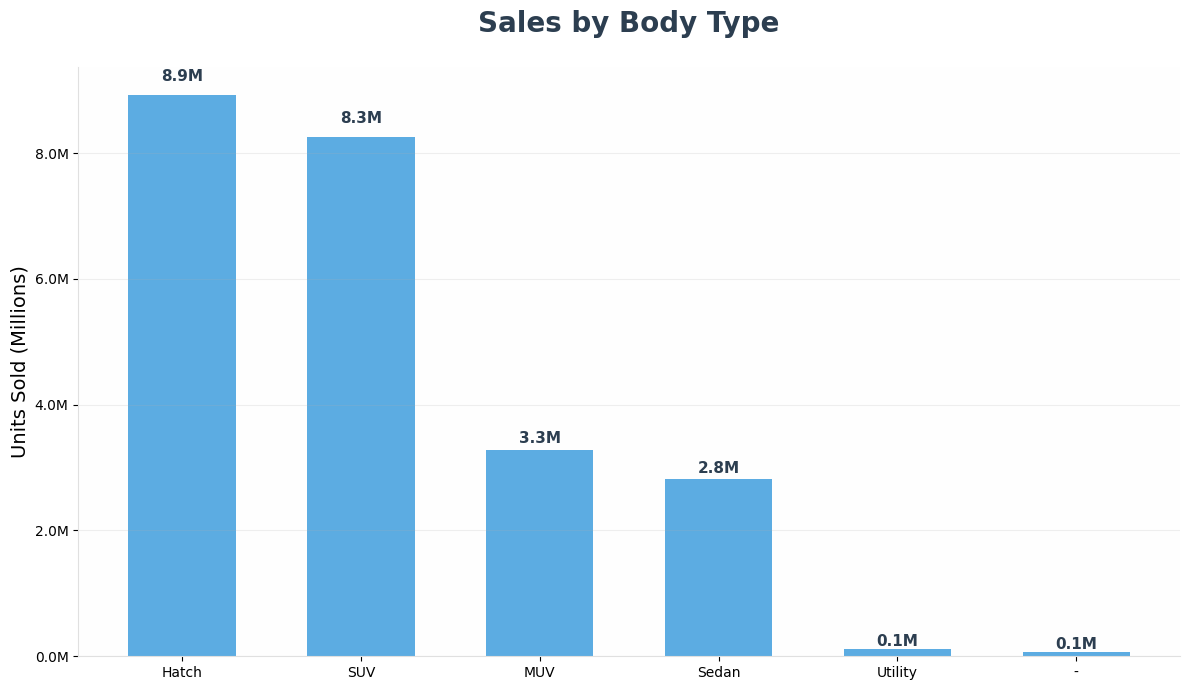

In [ ]:
def create_clean_body_type_chart(df):
    """Clean and minimal body type chart"""

    # Data preparation
    body_sales = df.groupby('Body')['Units_Sold'].sum().sort_values(ascending=False)
    body_sales = body_sales[body_sales > 0].head(6)

    # Create clean figure
    fig, ax = plt.subplots(figsize=(12, 7))
    fig.patch.set_facecolor('white')

    # Single beautiful color with gradient
    bars = ax.bar(body_sales.index, body_sales.values,
                  color='#3498DB', alpha=0.8, width=0.6)

    # Minimal value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{height/1000000:.1f}M', ha='center', va='bottom',
                fontweight='600', fontsize=11, color='#2C3E50')

    # Clean styling
    ax.set_title('Sales by Body Type', fontsize=20, fontweight='600',
                pad=25, color='#2C3E50')
    ax.set_ylabel('Units Sold (Millions)', fontsize=14, fontweight='500')

    # Remove clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')
    ax.grid(True, alpha=0.2, axis='y')
    ax.set_facecolor('#FEFEFE')

    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))

    plt.xticks(fontweight='500')
    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_body_type_chart(results['cleaned_data'])


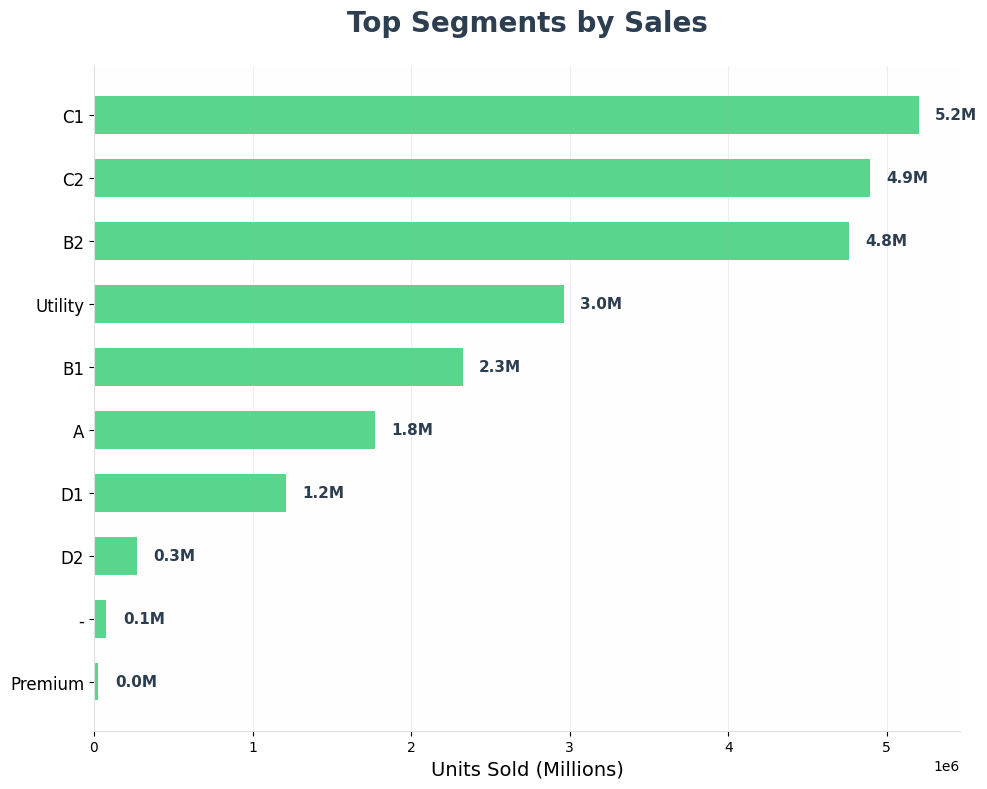

In [ ]:
def create_clean_segment_chart(df):
    """Clean and minimal segment chart"""

    # Data preparation
    segment_sales = df.groupby('Segment')['Units_Sold'].sum().sort_values(ascending=True)
    segment_sales = segment_sales[segment_sales > 0].tail(10)

    # Create clean figure
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('white')

    # Single color, clean bars
    bars = ax.barh(range(len(segment_sales)), segment_sales.values,
                   color='#2ECC71', alpha=0.8, height=0.6)

    # Simple value labels
    for i, value in enumerate(segment_sales.values):
        ax.text(value + max(segment_sales.values) * 0.02, i,
                f'{value/1000000:.1f}M', va='center', ha='left',
                fontweight='600', fontsize=11, color='#2C3E50')

    # Clean y-axis labels
    ax.set_yticks(range(len(segment_sales)))
    ax.set_yticklabels(segment_sales.index, fontsize=12, fontweight='500')

    # Minimal styling
    ax.set_title('Top Segments by Sales', fontsize=20, fontweight='600',
                pad=25, color='#2C3E50')
    ax.set_xlabel('Units Sold (Millions)', fontsize=14, fontweight='500')

    # Remove clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')
    ax.grid(True, alpha=0.2, axis='x')
    ax.set_facecolor('#FEFEFE')

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_segment_chart(results['cleaned_data'])


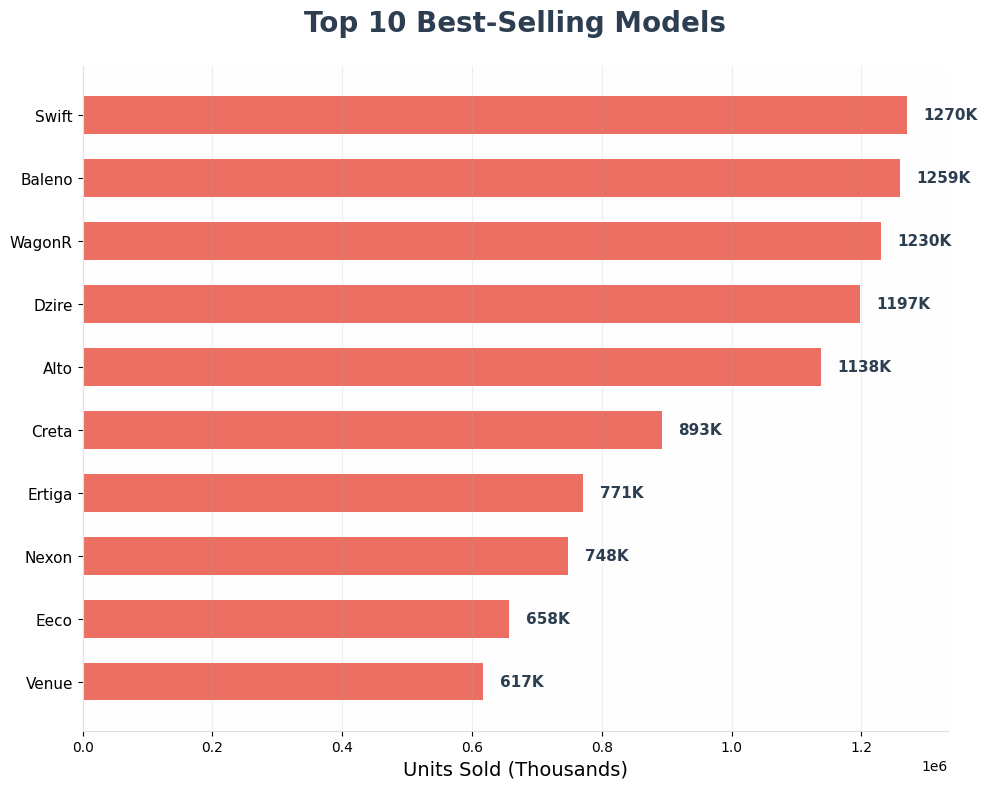

In [ ]:
def create_clean_top_models_chart(df):
    """Clean and minimal top models chart"""

    # Data preparation - only top 10 for clarity
    model_sales = df.groupby(['Manufacturer', 'Model'])['Units_Sold'].sum().sort_values(ascending=True).tail(10)

    # Simple labels
    model_labels = [f"{model}" for (mfg, model) in model_sales.index]

    # Create clean figure
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('white')

    # Single beautiful color
    bars = ax.barh(range(len(model_sales)), model_sales.values,
                   color='#E74C3C', alpha=0.8, height=0.6)

    # Clean value labels
    for i, value in enumerate(model_sales.values):
        ax.text(value + max(model_sales.values) * 0.02, i,
                f'{value/1000:.0f}K', va='center', ha='left',
                fontweight='600', fontsize=11, color='#2C3E50')

    # Simple y-axis labels
    ax.set_yticks(range(len(model_sales)))
    ax.set_yticklabels(model_labels, fontsize=11, fontweight='500')

    # Minimal styling
    ax.set_title('Top 10 Best-Selling Models', fontsize=20, fontweight='600',
                pad=25, color='#2C3E50')
    ax.set_xlabel('Units Sold (Thousands)', fontsize=14, fontweight='500')

    # Remove visual clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')
    ax.grid(True, alpha=0.2, axis='x')
    ax.set_facecolor('#FEFEFE')

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_top_models_chart(results['cleaned_data'])

# **Statistical Distribution Analysis**

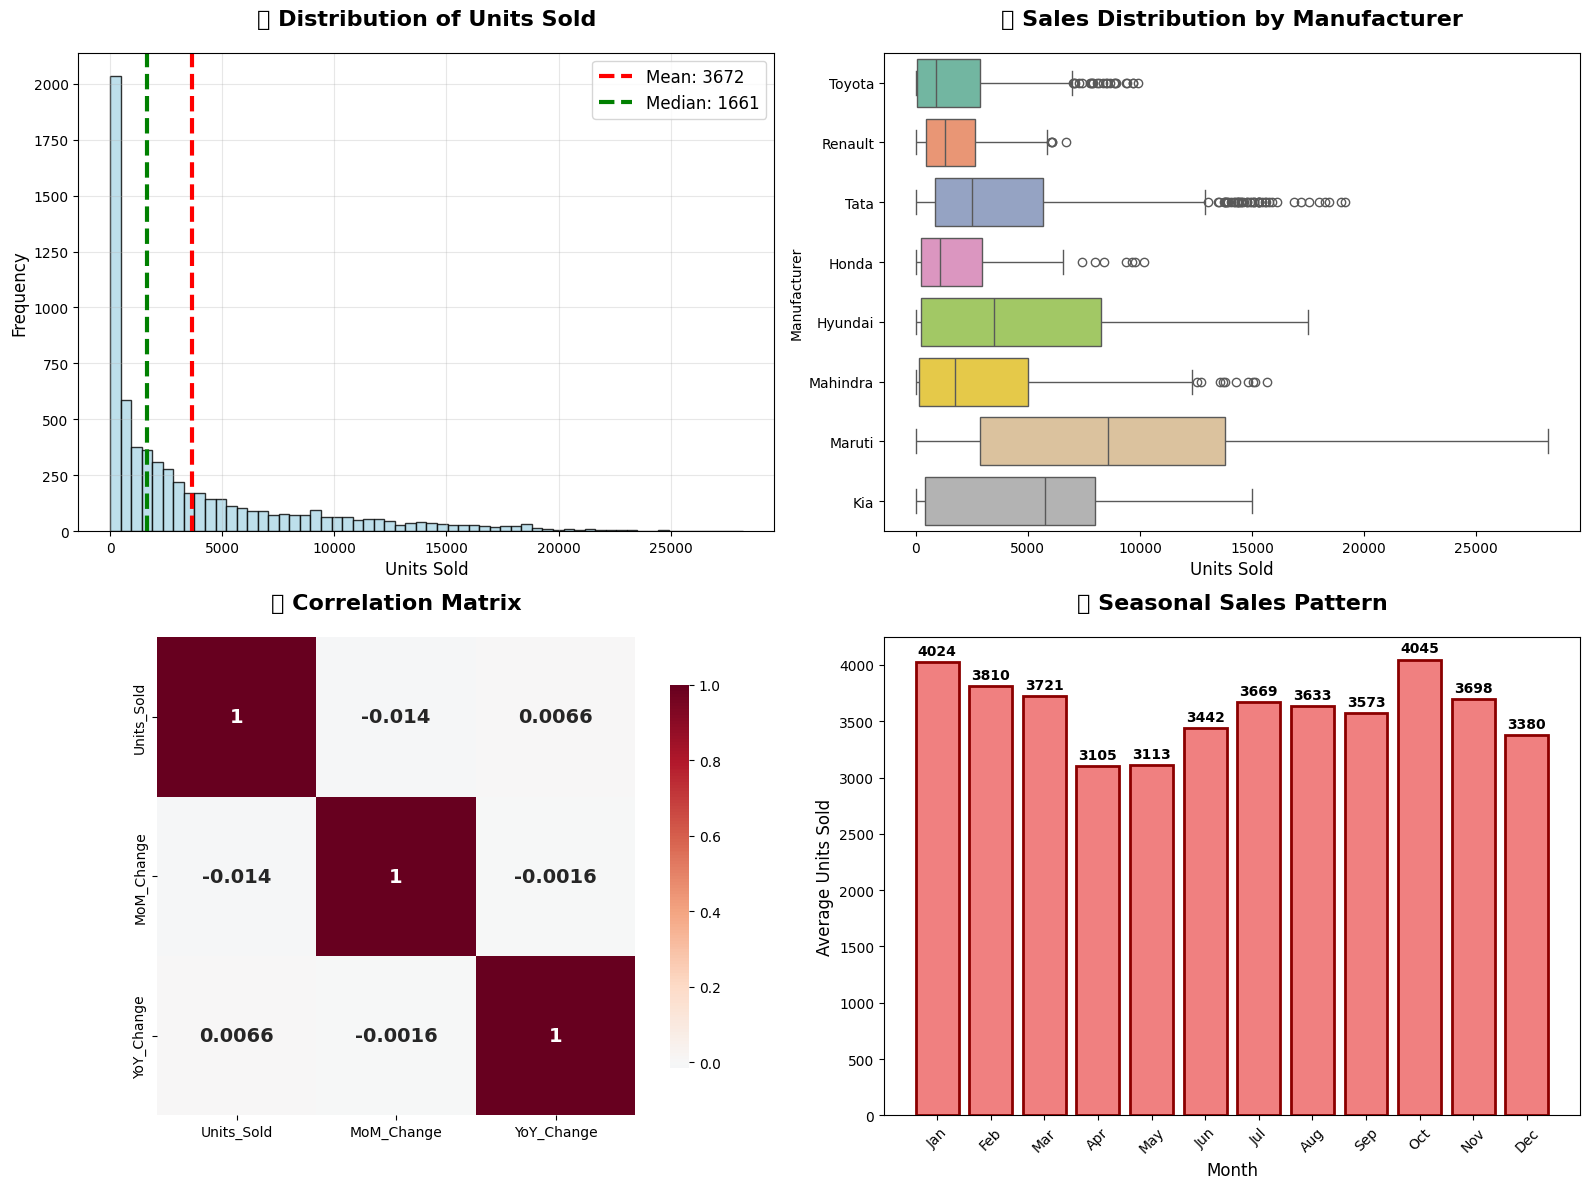

In [ ]:
def create_distribution_plots(df):
    """Distribution and statistical analysis"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Units Sold Distribution
    units_clean = df['Units_Sold'].dropna()
    units_clean = units_clean[units_clean > 0]

    axes[0,0].hist(units_clean, bins=60, alpha=0.8, color='lightblue', edgecolor='black', linewidth=1)

    mean_val = units_clean.mean()
    median_val = units_clean.median()
    axes[0,0].axvline(mean_val, color='red', linestyle='--', linewidth=3, label=f'Mean: {mean_val:.0f}')
    axes[0,0].axvline(median_val, color='green', linestyle='--', linewidth=3, label=f'Median: {median_val:.0f}')

    axes[0,0].set_title('📊 Distribution of Units Sold', fontsize=16, fontweight='bold', pad=20)
    axes[0,0].set_xlabel('Units Sold', fontsize=12)
    axes[0,0].set_ylabel('Frequency', fontsize=12)
    axes[0,0].legend(fontsize=12)
    axes[0,0].grid(True, alpha=0.3)

    # 2. Box Plot by Top Manufacturers
    top_manufacturers = df.groupby('Manufacturer')['Units_Sold'].sum().sort_values(ascending=False).head(8).index
    df_top_mfg = df[df['Manufacturer'].isin(top_manufacturers)]

    sns.boxplot(data=df_top_mfg, y='Manufacturer', x='Units_Sold', ax=axes[0,1], palette='Set2')
    axes[0,1].set_title('📦 Sales Distribution by Manufacturer', fontsize=16, fontweight='bold', pad=20)
    axes[0,1].set_xlabel('Units Sold', fontsize=12)

    # 3. Correlation Heatmap
    corr_data = df[['Units_Sold', 'MoM_Change', 'YoY_Change']].dropna()
    correlation_matrix = corr_data.corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, ax=axes[1,0], cbar_kws={"shrink": .8},
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    axes[1,0].set_title('🔥 Correlation Matrix', fontsize=16, fontweight='bold', pad=20)

    # 4. Seasonal Pattern
    monthly_avg = df.groupby('Month')['Units_Sold'].mean().reset_index()
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_avg['Month'] = pd.Categorical(monthly_avg['Month'], categories=month_order, ordered=True)
    monthly_avg = monthly_avg.sort_values('Month')

    bars = axes[1,1].bar(monthly_avg['Month'], monthly_avg['Units_Sold'],
                        color='lightcoral', edgecolor='darkred', linewidth=2)
    axes[1,1].set_title('🌟 Seasonal Sales Pattern', fontsize=16, fontweight='bold', pad=20)
    axes[1,1].set_xlabel('Month', fontsize=12)
    axes[1,1].set_ylabel('Average Units Sold', fontsize=12)
    axes[1,1].tick_params(axis='x', rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{height:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run this plot
create_distribution_plots(results['cleaned_data'])

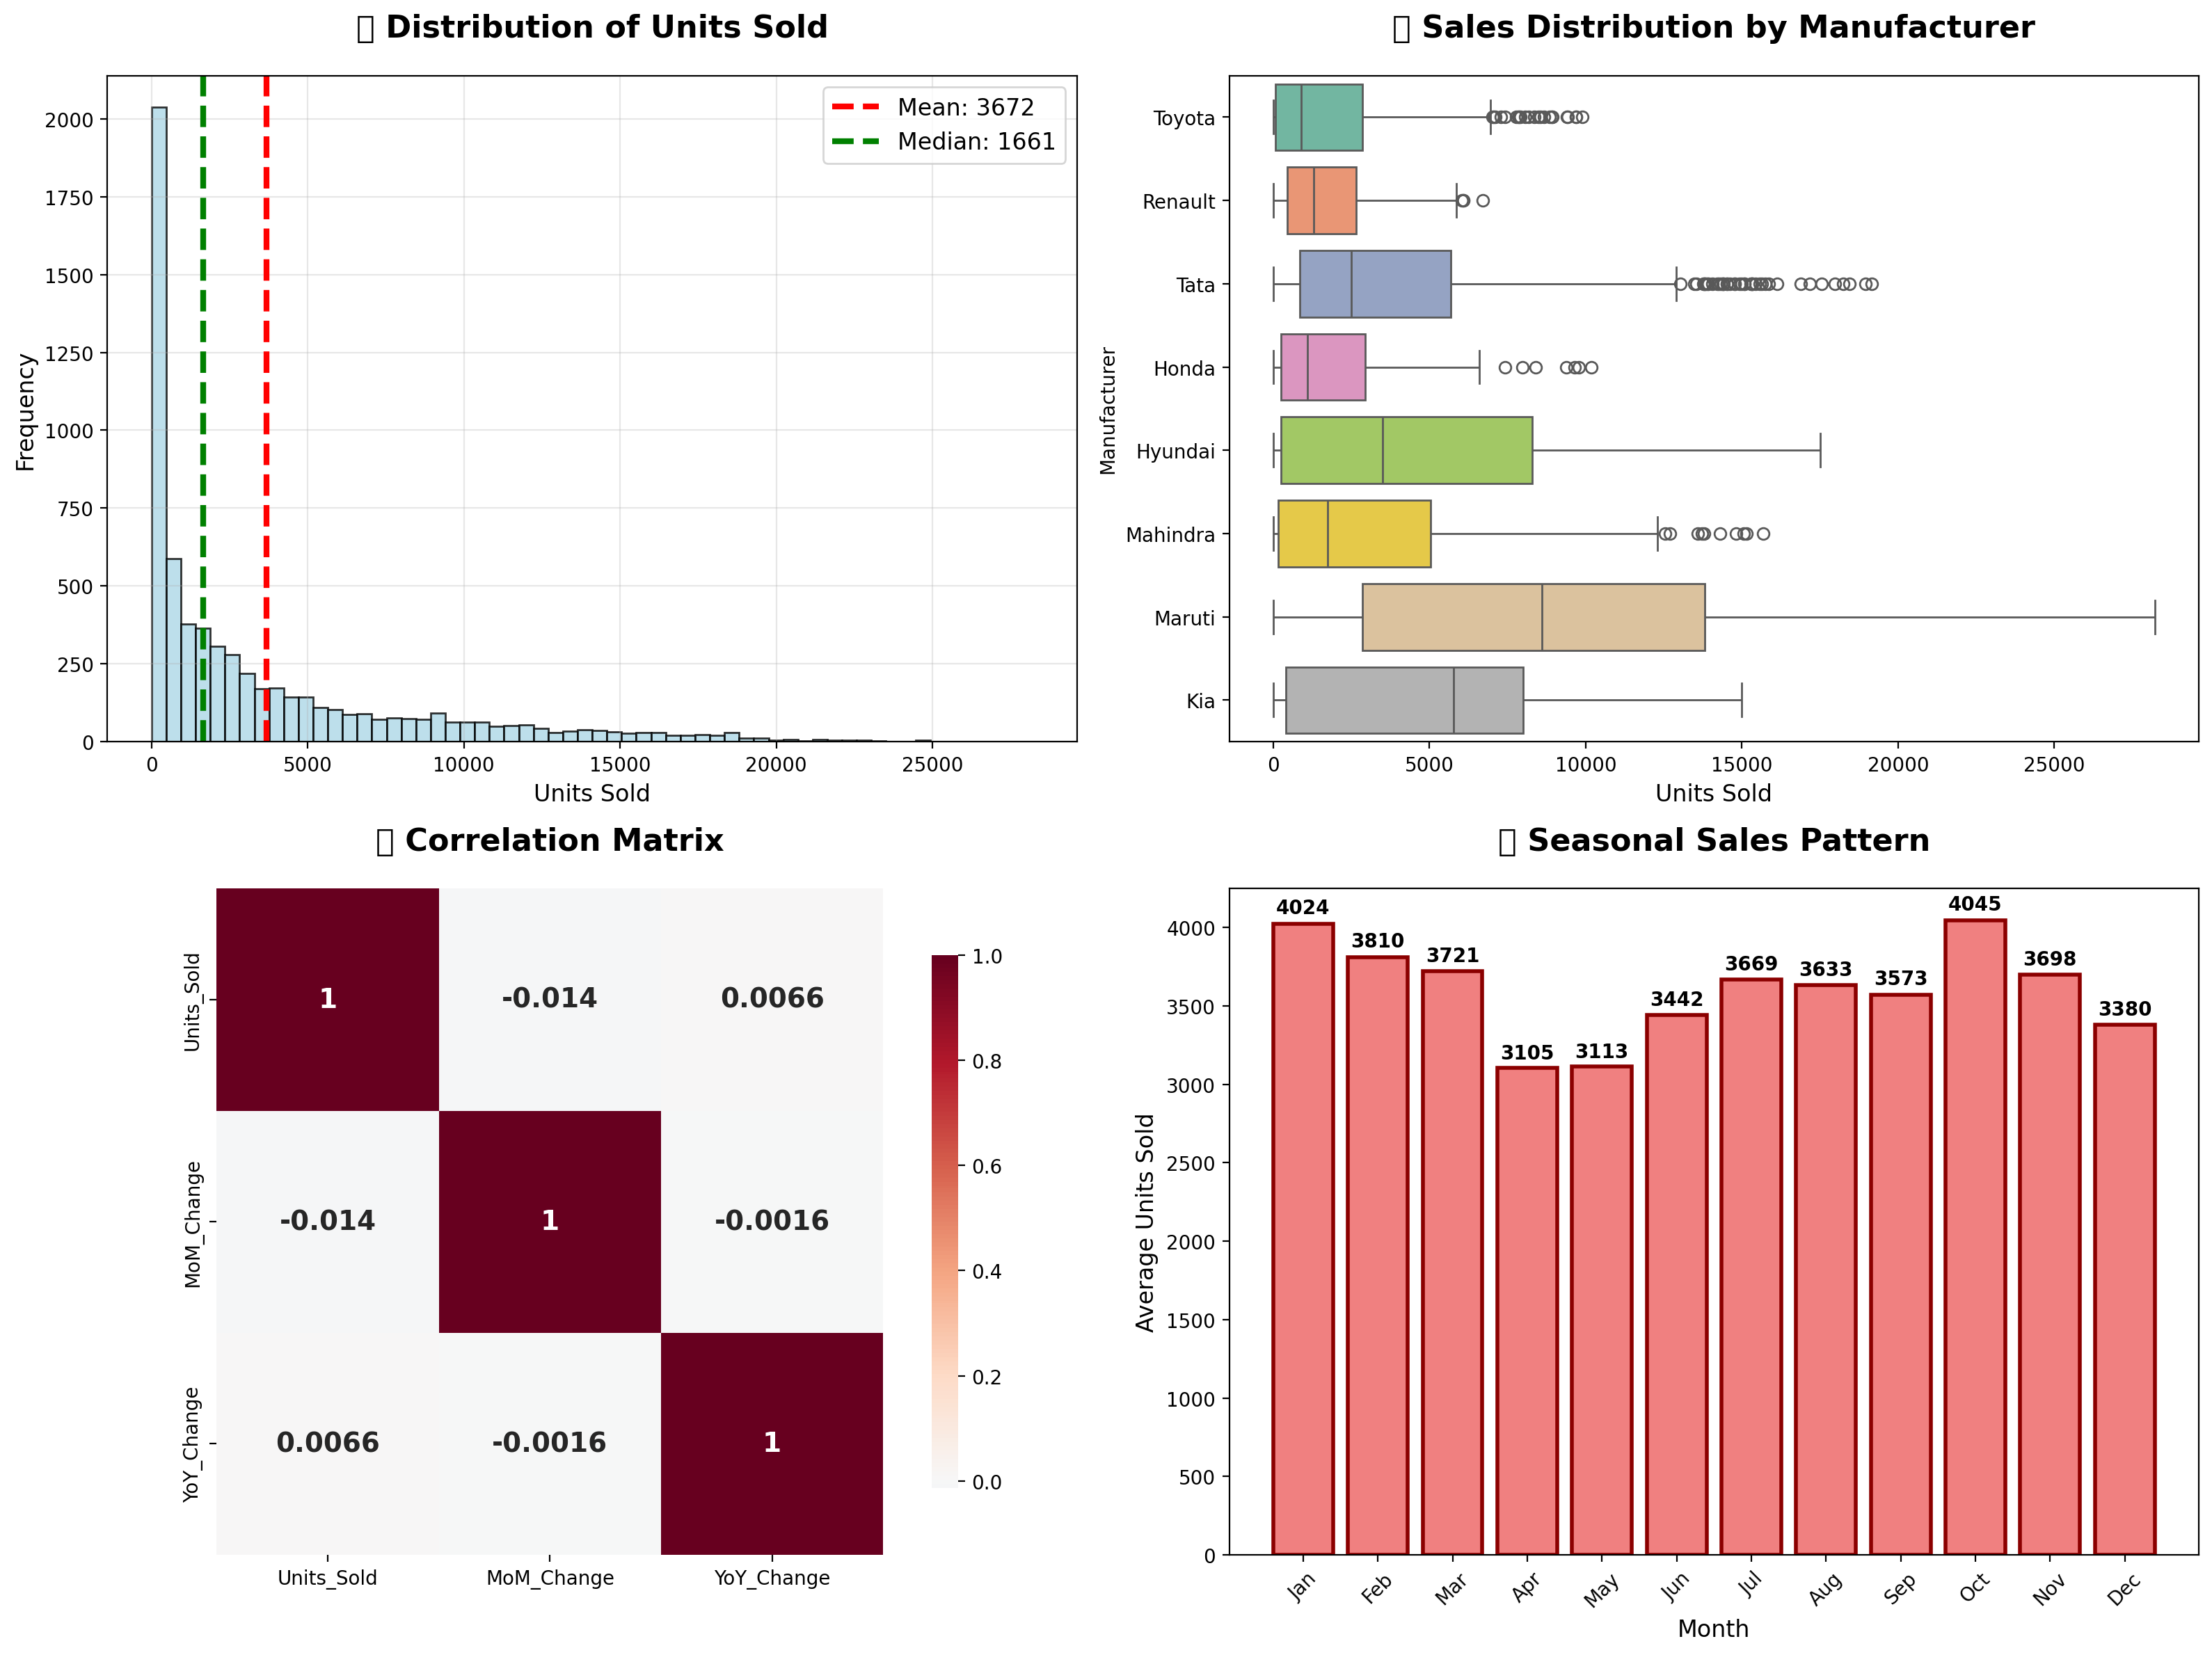

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set high DPI for crystal clear plots
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

def create_distribution_plots(df):
    """Distribution and statistical analysis with high DPI"""

    # Create figure with high DPI
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=200)

    # 1. Units Sold Distribution
    units_clean = df['Units_Sold'].dropna()
    units_clean = units_clean[units_clean > 0]

    axes[0,0].hist(units_clean, bins=60, alpha=0.8, color='lightblue', edgecolor='black', linewidth=1)

    mean_val = units_clean.mean()
    median_val = units_clean.median()
    axes[0,0].axvline(mean_val, color='red', linestyle='--', linewidth=3, label=f'Mean: {mean_val:.0f}')
    axes[0,0].axvline(median_val, color='green', linestyle='--', linewidth=3, label=f'Median: {median_val:.0f}')

    axes[0,0].set_title('📊 Distribution of Units Sold', fontsize=16, fontweight='bold', pad=20)
    axes[0,0].set_xlabel('Units Sold', fontsize=12)
    axes[0,0].set_ylabel('Frequency', fontsize=12)
    axes[0,0].legend(fontsize=12)
    axes[0,0].grid(True, alpha=0.3)

    # 2. Box Plot by Top Manufacturers
    top_manufacturers = df.groupby('Manufacturer')['Units_Sold'].sum().sort_values(ascending=False).head(8).index
    df_top_mfg = df[df['Manufacturer'].isin(top_manufacturers)]

    sns.boxplot(data=df_top_mfg, y='Manufacturer', x='Units_Sold', ax=axes[0,1], palette='Set2')
    axes[0,1].set_title('📦 Sales Distribution by Manufacturer', fontsize=16, fontweight='bold', pad=20)
    axes[0,1].set_xlabel('Units Sold', fontsize=12)

    # 3. Correlation Heatmap
    corr_data = df[['Units_Sold', 'MoM_Change', 'YoY_Change']].dropna()
    correlation_matrix = corr_data.corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, ax=axes[1,0], cbar_kws={"shrink": .8},
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    axes[1,0].set_title('🔥 Correlation Matrix', fontsize=16, fontweight='bold', pad=20)

    # 4. Seasonal Pattern
    monthly_avg = df.groupby('Month')['Units_Sold'].mean().reset_index()
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_avg['Month'] = pd.Categorical(monthly_avg['Month'], categories=month_order, ordered=True)
    monthly_avg = monthly_avg.sort_values('Month')

    bars = axes[1,1].bar(monthly_avg['Month'], monthly_avg['Units_Sold'],
                        color='lightcoral', edgecolor='darkred', linewidth=2)
    axes[1,1].set_title('🌟 Seasonal Sales Pattern', fontsize=16, fontweight='bold', pad=20)
    axes[1,1].set_xlabel('Month', fontsize=12)
    axes[1,1].set_ylabel('Average Units Sold', fontsize=12)
    axes[1,1].tick_params(axis='x', rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{height:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run this plot
create_distribution_plots(results['cleaned_data'])

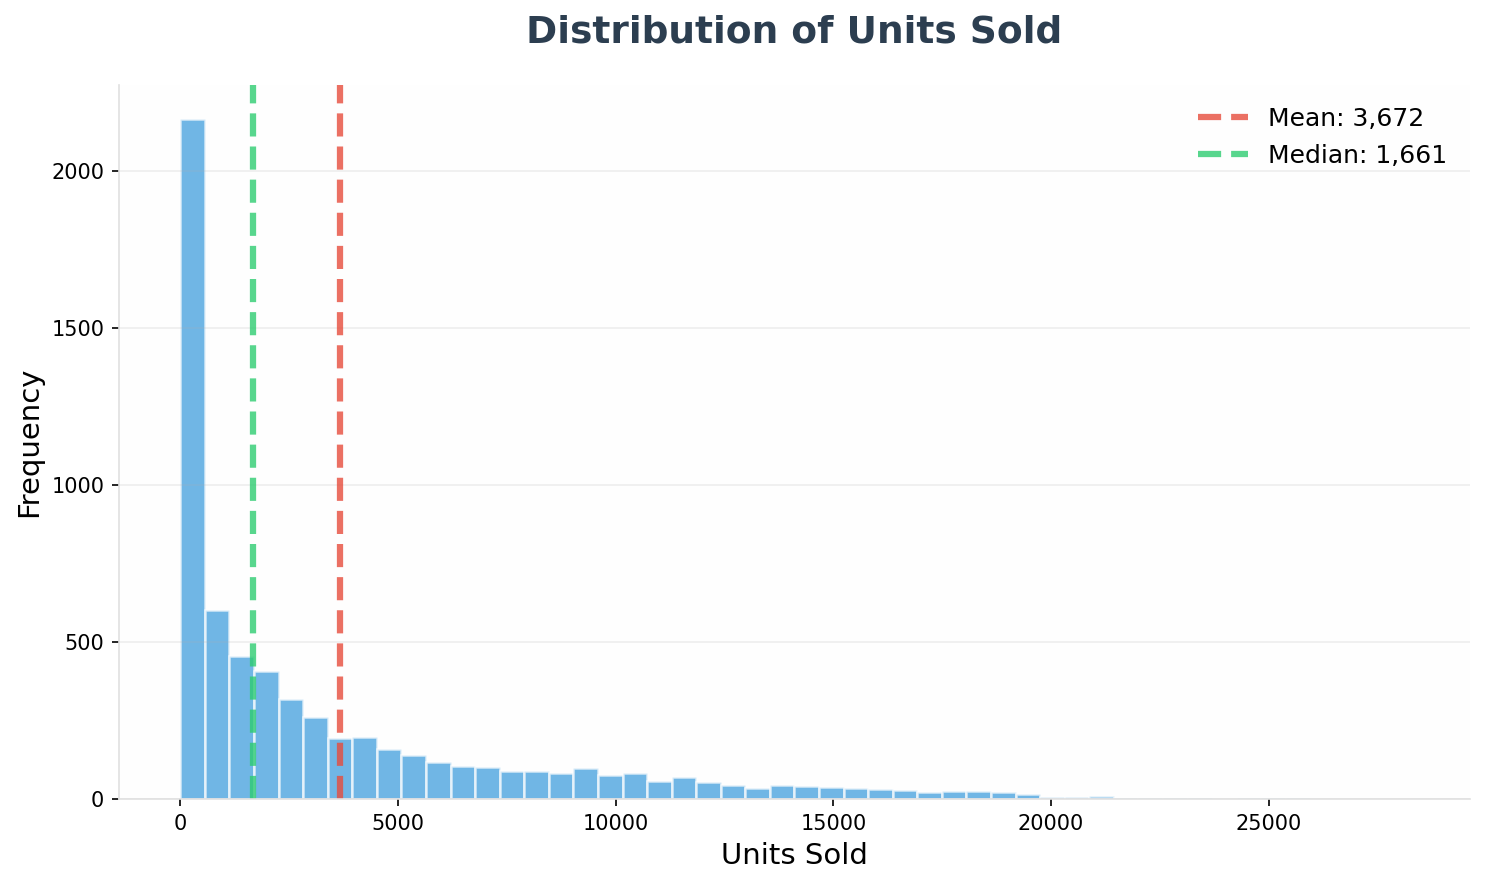

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Set high DPI for crystal clear plots
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

def create_clean_units_distribution(df):
    """Clean and crisp units sold distribution"""

    # Data preparation
    units_clean = df['Units_Sold'].dropna()
    units_clean = units_clean[units_clean > 0]

    # Create high-quality figure
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('white')

    # Beautiful histogram
    ax.hist(units_clean, bins=50, alpha=0.7, color='#3498DB',
            edgecolor='white', linewidth=1.2)

    # Statistical lines
    mean_val = units_clean.mean()
    median_val = units_clean.median()

    ax.axvline(mean_val, color='#E74C3C', linestyle='--', linewidth=3,
               label=f'Mean: {mean_val:,.0f}', alpha=0.8)
    ax.axvline(median_val, color='#2ECC71', linestyle='--', linewidth=3,
               label=f'Median: {median_val:,.0f}', alpha=0.8)

    # Clean styling
    ax.set_title('Distribution of Units Sold', fontsize=18, fontweight='600',
                pad=20, color='#2C3E50')
    ax.set_xlabel('Units Sold', fontsize=14, fontweight='500')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='500')

    # Legend and grid
    ax.legend(fontsize=12, frameon=False)
    ax.grid(True, alpha=0.2, axis='y')

    # Remove clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')
    ax.set_facecolor('#FEFEFE')

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_units_distribution(results['cleaned_data'])

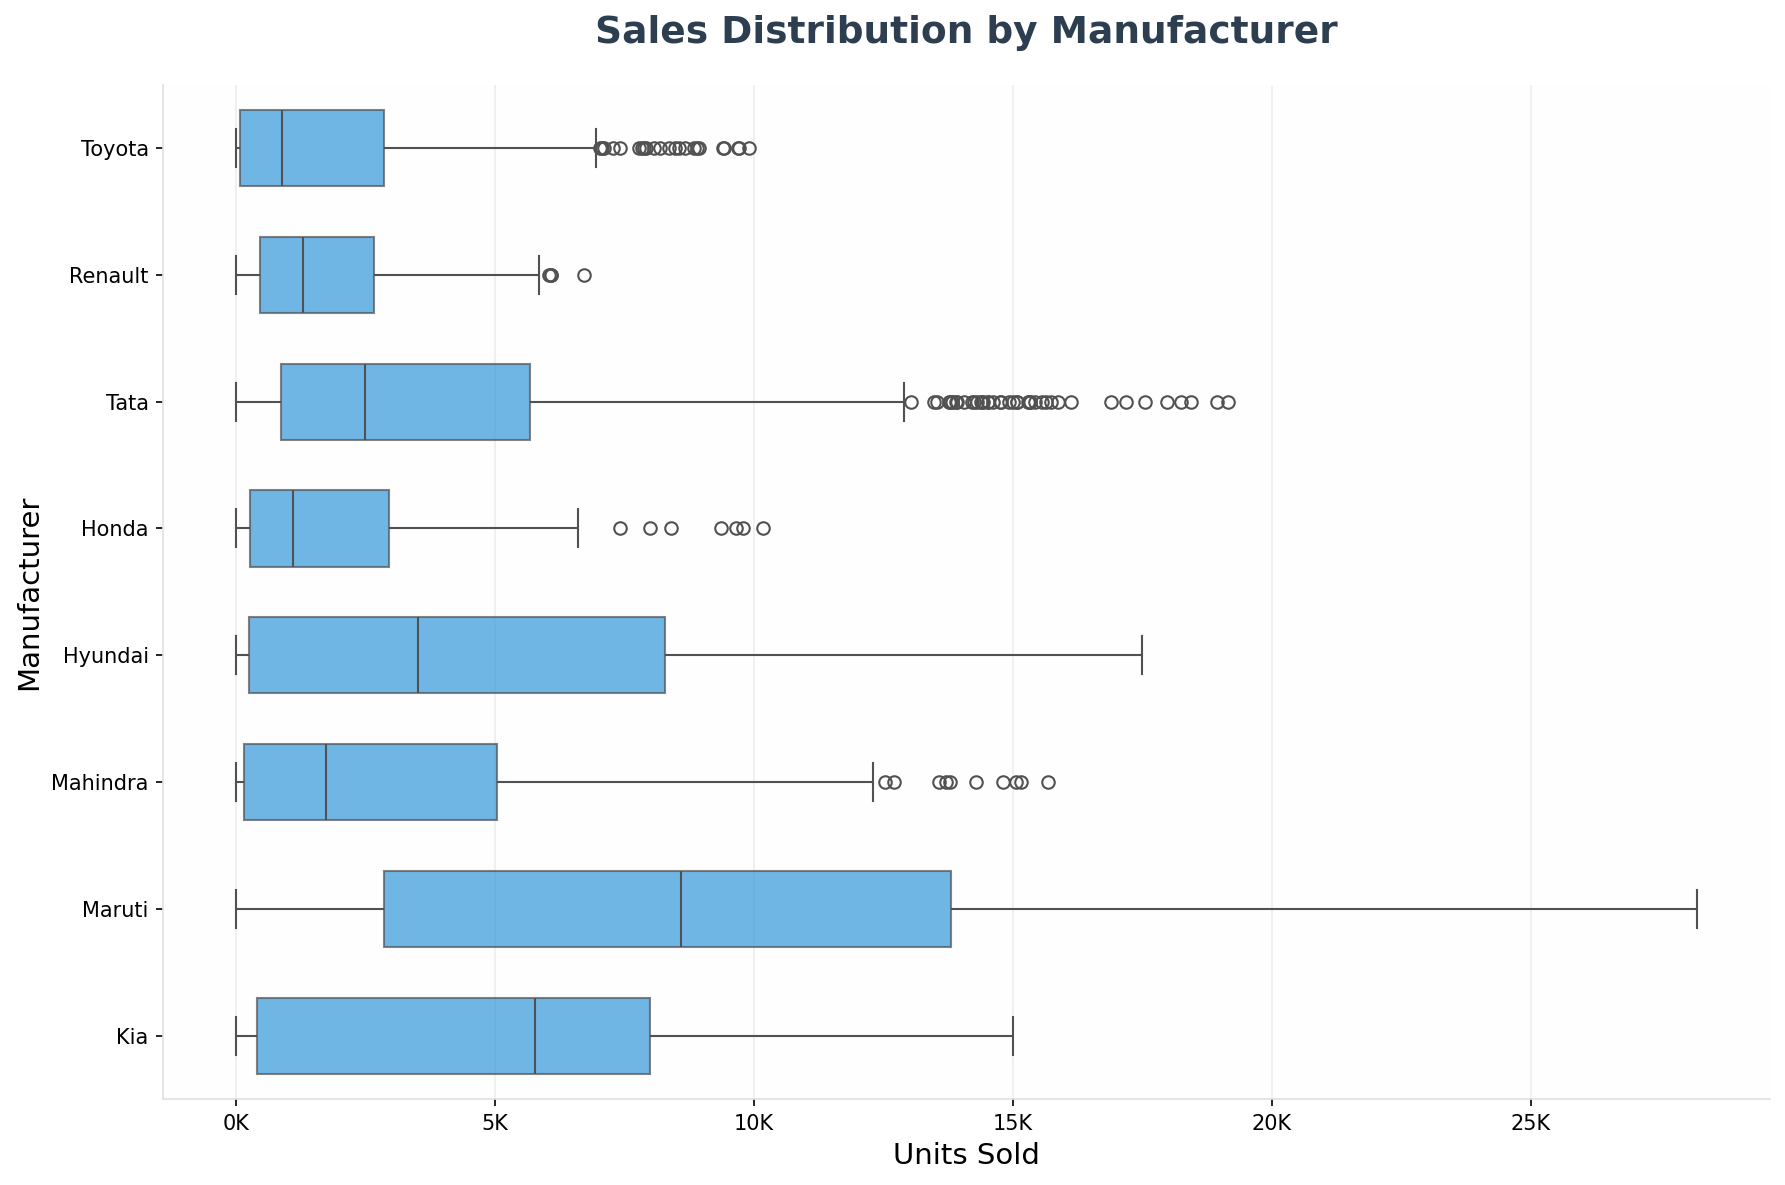

In [ ]:
def create_clean_manufacturer_boxplot(df):
    """Clean manufacturer sales distribution box plot"""

    # Data preparation
    top_manufacturers = df.groupby('Manufacturer')['Units_Sold'].sum().sort_values(ascending=False).head(8).index
    df_top_mfg = df[df['Manufacturer'].isin(top_manufacturers)]

    # Create high-quality figure
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')

    # Beautiful box plot
    bp = sns.boxplot(data=df_top_mfg, y='Manufacturer', x='Units_Sold',
                     ax=ax, palette=['#3498DB'], width=0.6)

    # Customize box plot colors
    for patch in bp.patches:
        patch.set_facecolor('#3498DB')
        patch.set_alpha(0.7)

    # Clean styling
    ax.set_title('Sales Distribution by Manufacturer', fontsize=18, fontweight='600',
                pad=20, color='#2C3E50')
    ax.set_xlabel('Units Sold', fontsize=14, fontweight='500')
    ax.set_ylabel('Manufacturer', fontsize=14, fontweight='500')

    # Format x-axis
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

    # Remove clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')
    ax.grid(True, alpha=0.2, axis='x')
    ax.set_facecolor('#FEFEFE')

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_manufacturer_boxplot(results['cleaned_data'])

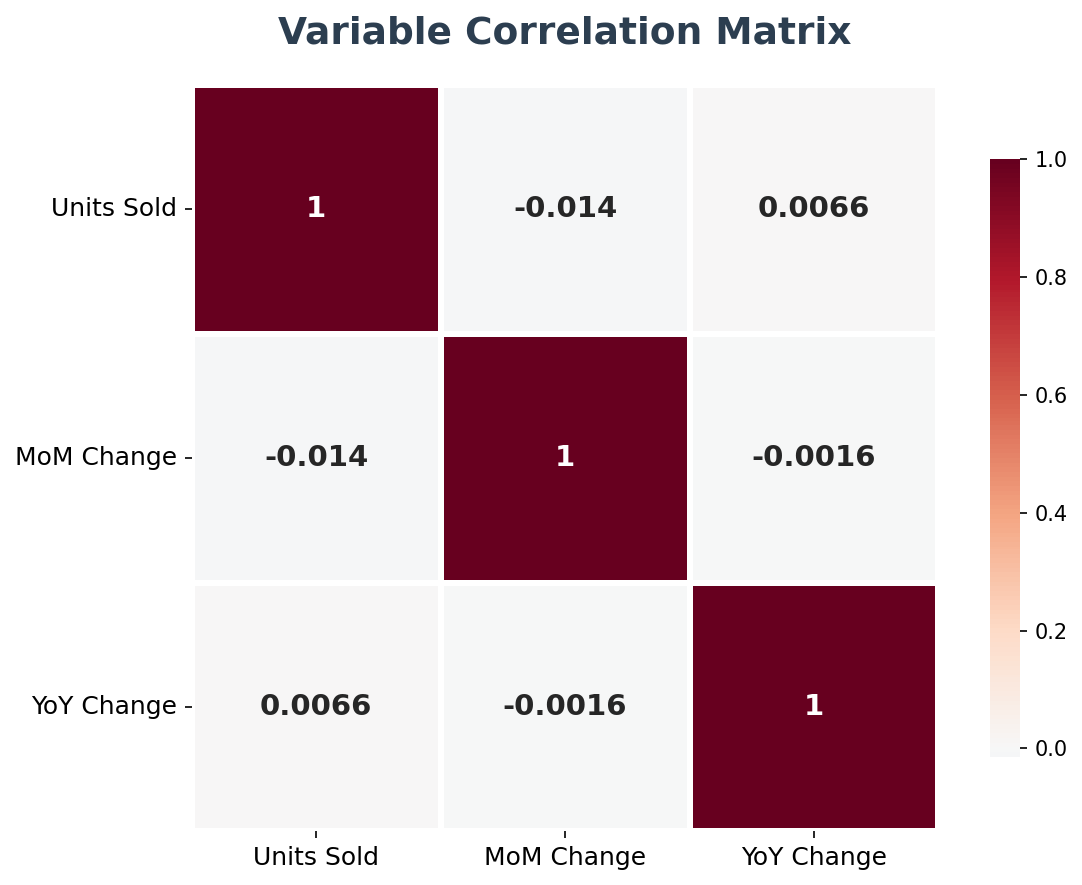

In [ ]:
def create_clean_correlation_heatmap(df):
    """Clean and minimal correlation heatmap"""

    # Data preparation
    corr_data = df[['Units_Sold', 'MoM_Change', 'YoY_Change']].dropna()
    correlation_matrix = corr_data.corr()

    # Create high-quality figure
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('white')

    # Beautiful heatmap
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax,
                cbar_kws={"shrink": 0.8, "aspect": 20},
                annot_kws={'fontsize': 14, 'fontweight': '600'},
                linewidths=2,
                linecolor='white')

    # Clean styling
    ax.set_title('Variable Correlation Matrix', fontsize=18, fontweight='600',
                pad=20, color='#2C3E50')

    # Clean labels
    ax.set_xticklabels(['Units Sold', 'MoM Change', 'YoY Change'],
                       fontsize=12, fontweight='500')
    ax.set_yticklabels(['Units Sold', 'MoM Change', 'YoY Change'],
                       fontsize=12, fontweight='500', rotation=0)

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_correlation_heatmap(results['cleaned_data'])

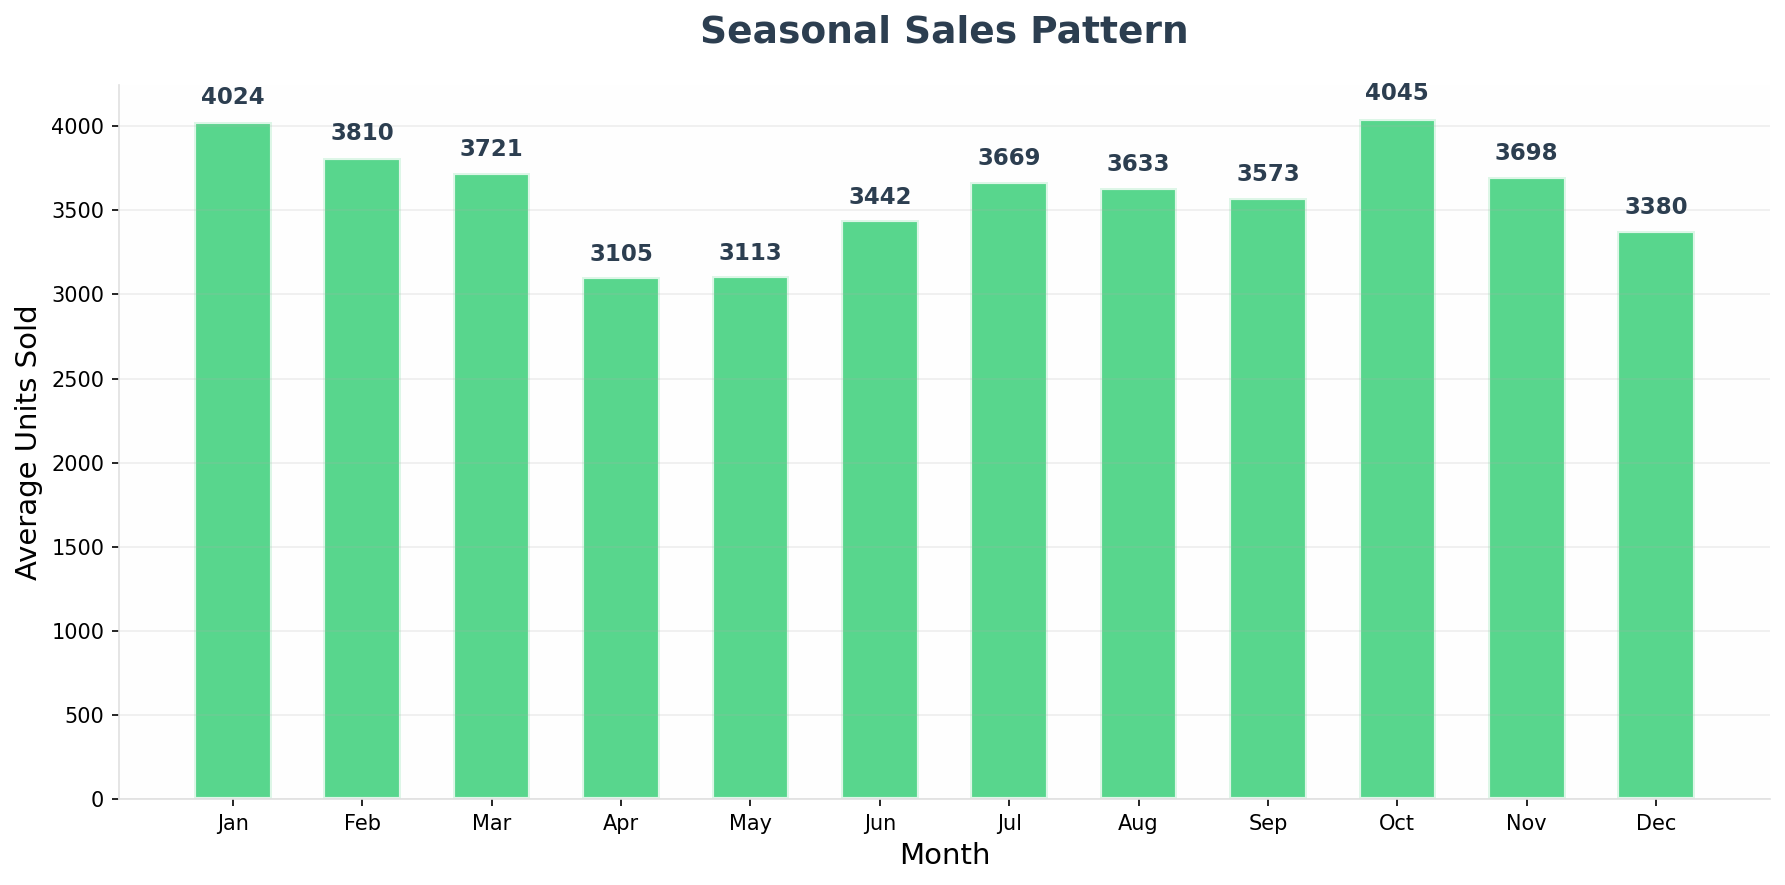

In [ ]:
def create_clean_seasonal_pattern(df):
    """Clean seasonal sales pattern chart"""

    # Data preparation
    monthly_avg = df.groupby('Month')['Units_Sold'].mean().reset_index()
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_avg['Month'] = pd.Categorical(monthly_avg['Month'],
                                         categories=month_order, ordered=True)
    monthly_avg = monthly_avg.sort_values('Month')

    # Create high-quality figure
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')

    # Beautiful bars
    bars = ax.bar(monthly_avg['Month'], monthly_avg['Units_Sold'],
                  color='#2ECC71', alpha=0.8, width=0.6,
                  edgecolor='white', linewidth=2)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{height:.0f}', ha='center', va='bottom',
                fontsize=11, fontweight='600', color='#2C3E50')

    # Clean styling
    ax.set_title('Seasonal Sales Pattern', fontsize=18, fontweight='600',
                pad=20, color='#2C3E50')
    ax.set_xlabel('Month', fontsize=14, fontweight='500')
    ax.set_ylabel('Average Units Sold', fontsize=14, fontweight='500')

    # Remove clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#E0E0E0')
    ax.spines['bottom'].set_color('#E0E0E0')
    ax.grid(True, alpha=0.2, axis='y')
    ax.set_facecolor('#FEFEFE')

    # Rotate labels slightly for better readability
    plt.xticks(rotation=0, fontweight='500')

    plt.tight_layout()
    plt.show()

# Run this plot
create_clean_seasonal_pattern(results['cleaned_data'])

# **Advanced Analytics & Growth Analysis**

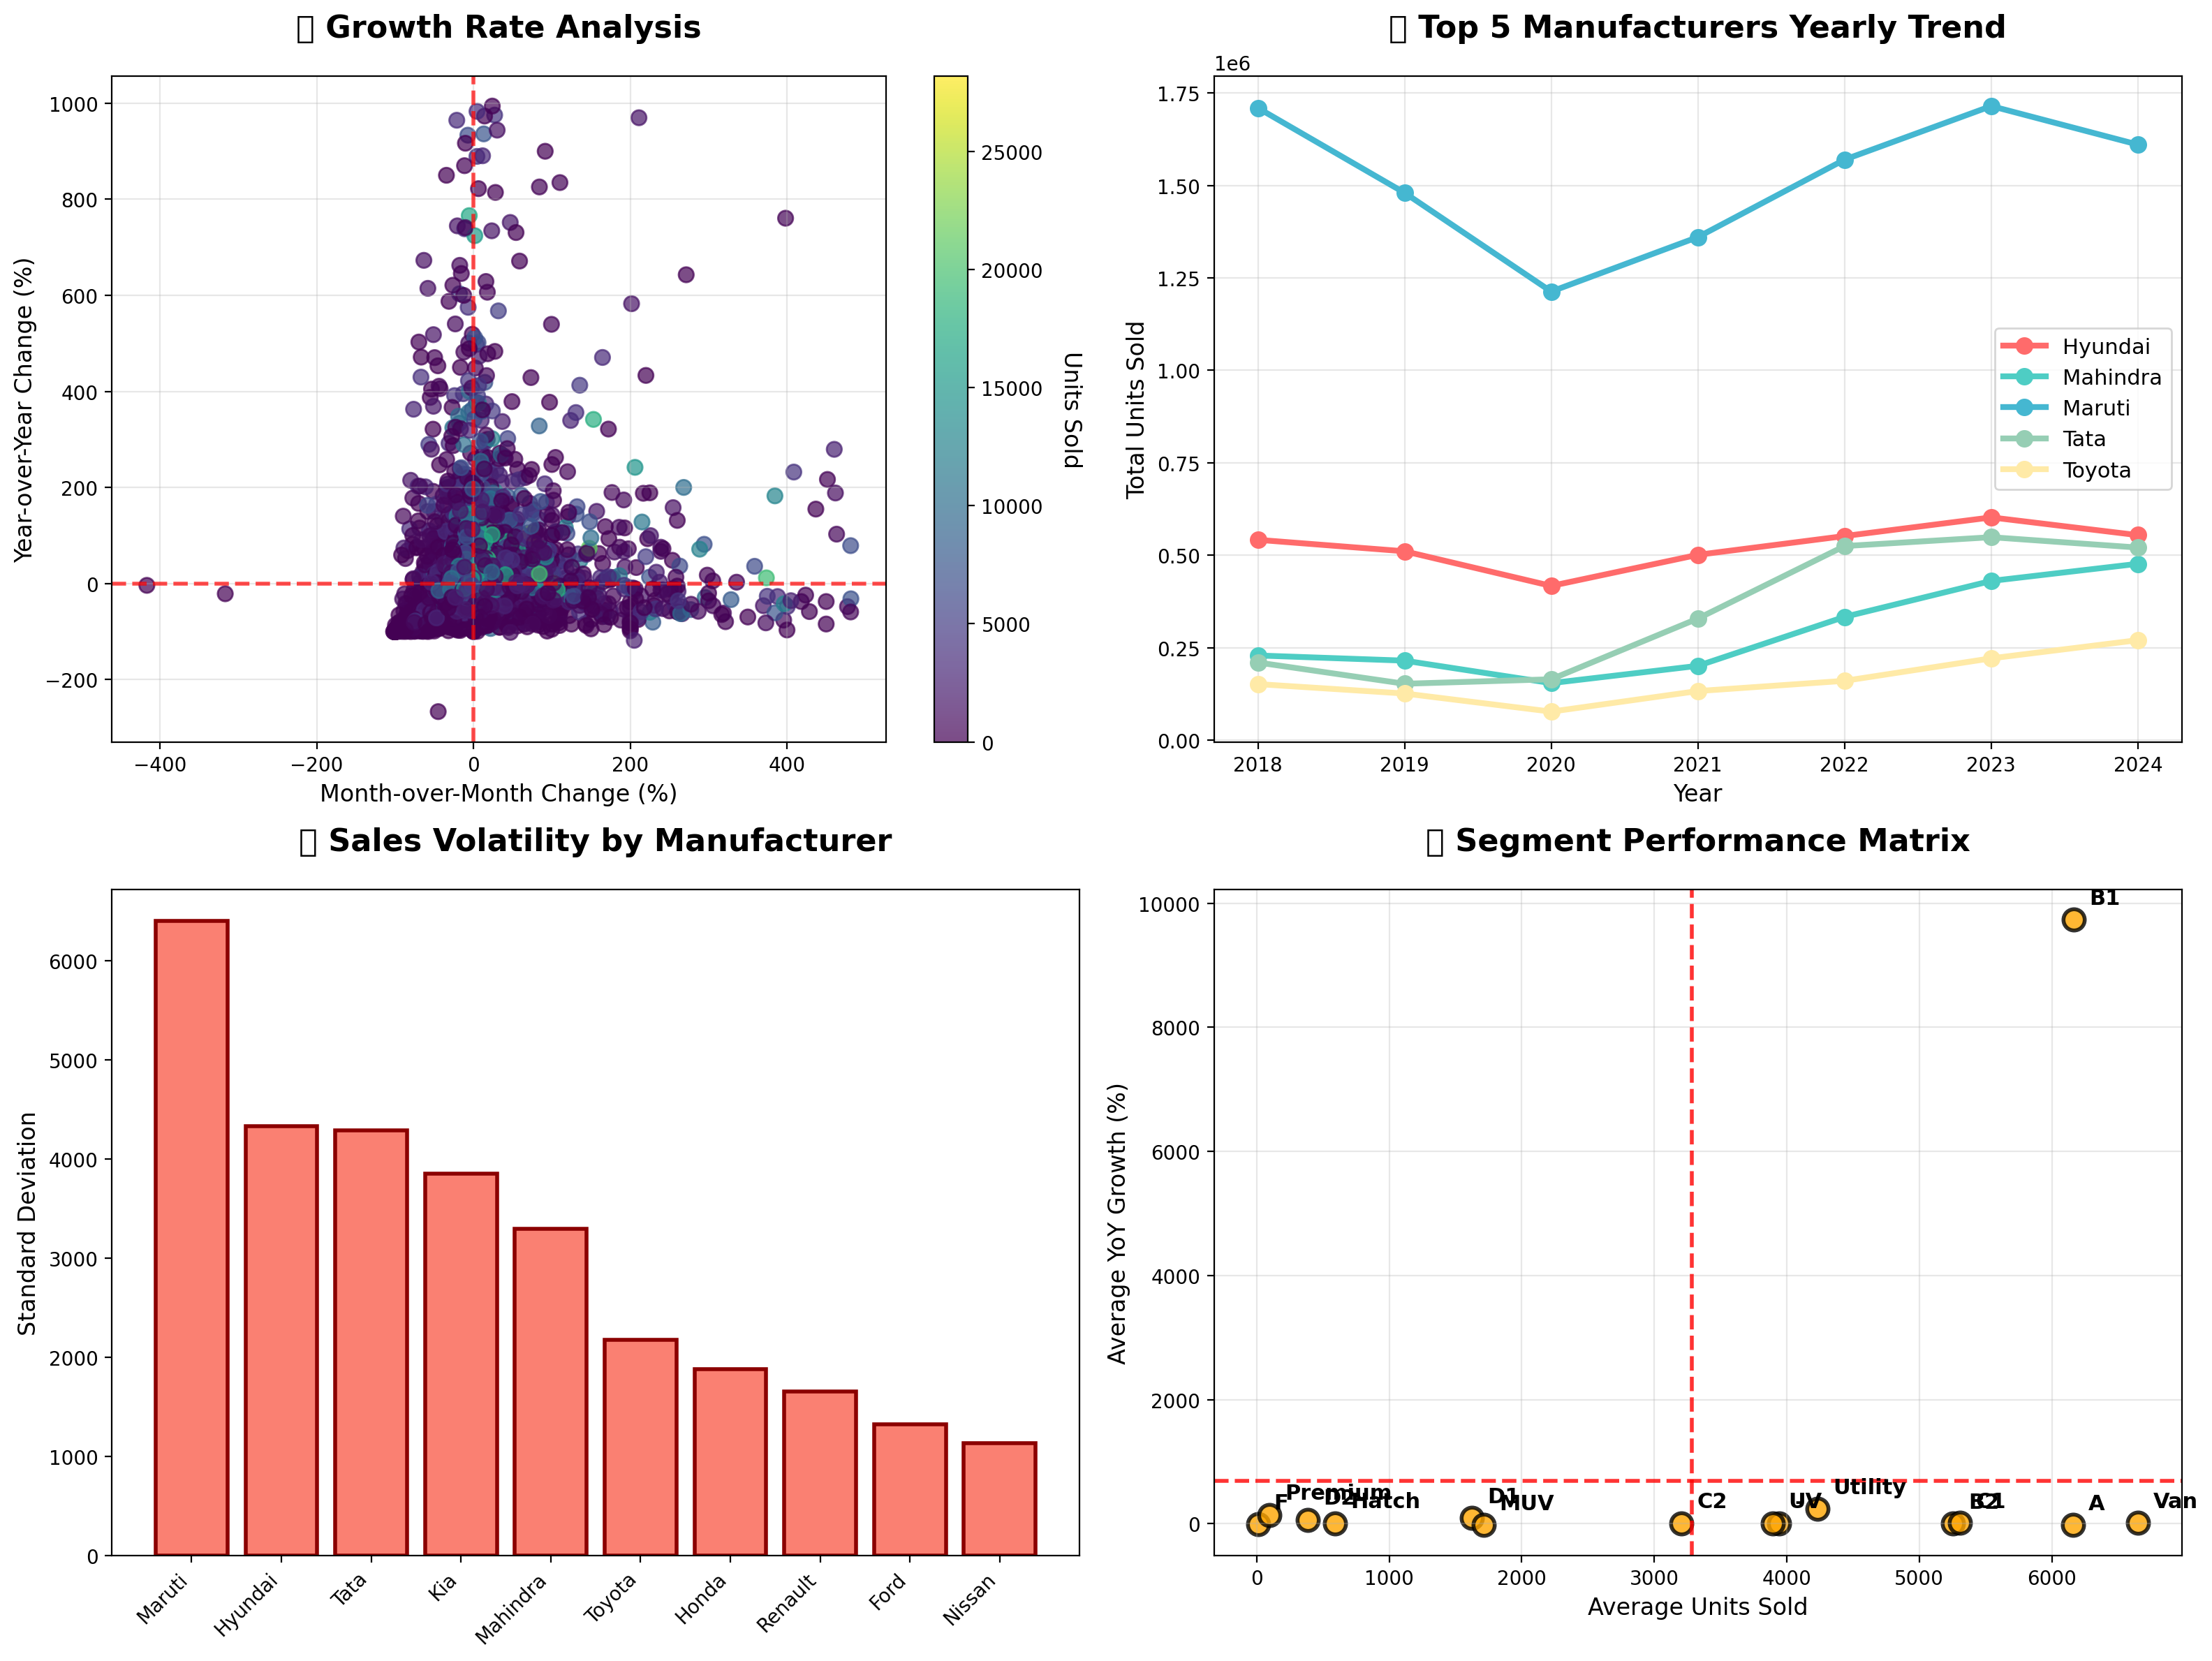

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set high DPI for crystal clear plots
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

def create_advanced_analytics_plots(df):
    """Advanced analytics and growth patterns with high DPI"""

    # Create figure with high DPI
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=200)

    # 1. Growth Rate Scatter Plot
    growth_data = df.dropna(subset=['MoM_Change', 'YoY_Change', 'Units_Sold'])
    growth_data_filtered = growth_data[(abs(growth_data['MoM_Change']) < 500) &
                                      (abs(growth_data['YoY_Change']) < 1000)]

    scatter = axes[0,0].scatter(growth_data_filtered['MoM_Change'], growth_data_filtered['YoY_Change'],
                               c=growth_data_filtered['Units_Sold'], cmap='viridis', alpha=0.7, s=60)
    axes[0,0].set_title('📈 Growth Rate Analysis', fontsize=16, fontweight='bold', pad=20)
    axes[0,0].set_xlabel('Month-over-Month Change (%)', fontsize=12)
    axes[0,0].set_ylabel('Year-over-Year Change (%)', fontsize=12)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    axes[0,0].grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter, ax=axes[0,0])
    cbar.set_label('Units Sold', rotation=270, labelpad=20, fontsize=12)

    # 2. Top Manufacturers Trend
    top_5_mfg = df.groupby('Manufacturer')['Units_Sold'].sum().sort_values(ascending=False).head(5).index
    yearly_mfg_data = df[df['Manufacturer'].isin(top_5_mfg)].groupby(['Year', 'Manufacturer'])['Units_Sold'].sum().unstack(fill_value=0)

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    for i, mfg in enumerate(yearly_mfg_data.columns):
        axes[0,1].plot(yearly_mfg_data.index, yearly_mfg_data[mfg],
                      marker='o', linewidth=3, markersize=8, label=mfg, color=colors[i])

    axes[0,1].set_title('🏆 Top 5 Manufacturers Yearly Trend', fontsize=16, fontweight='bold', pad=20)
    axes[0,1].set_xlabel('Year', fontsize=12)
    axes[0,1].set_ylabel('Total Units Sold', fontsize=12)
    axes[0,1].legend(fontsize=11)
    axes[0,1].grid(True, alpha=0.3)

    # 3. Sales Volatility
    mfg_volatility = df.groupby('Manufacturer').agg({
        'Units_Sold': ['mean', 'std']
    }).round(0)
    mfg_volatility.columns = ['Mean_Sales', 'Volatility']
    mfg_volatility = mfg_volatility.dropna().sort_values('Volatility', ascending=False).head(10)

    bars = axes[1,0].bar(range(len(mfg_volatility)), mfg_volatility['Volatility'],
                        color='salmon', edgecolor='darkred', linewidth=2)
    axes[1,0].set_xticks(range(len(mfg_volatility)))
    axes[1,0].set_xticklabels(mfg_volatility.index, rotation=45, ha='right', fontsize=10)
    axes[1,0].set_title('📊 Sales Volatility by Manufacturer', fontsize=16, fontweight='bold', pad=20)
    axes[1,0].set_ylabel('Standard Deviation', fontsize=12)

    # 4. Performance Matrix
    segment_perf = df.groupby('Segment').agg({
        'Units_Sold': 'mean',
        'YoY_Change': 'mean'
    }).dropna()

    avg_units = segment_perf['Units_Sold'].mean()
    avg_growth = segment_perf['YoY_Change'].mean()

    scatter = axes[1,1].scatter(segment_perf['Units_Sold'], segment_perf['YoY_Change'],
                               s=120, alpha=0.8, c='orange', edgecolors='black', linewidth=2)

    for i, txt in enumerate(segment_perf.index):
        axes[1,1].annotate(txt, (segment_perf['Units_Sold'].iloc[i], segment_perf['YoY_Change'].iloc[i]),
                          xytext=(8, 8), textcoords='offset points', fontsize=11, fontweight='bold')

    axes[1,1].axhline(y=avg_growth, color='red', linestyle='--', alpha=0.8, linewidth=2)
    axes[1,1].axvline(x=avg_units, color='red', linestyle='--', alpha=0.8, linewidth=2)
    axes[1,1].set_title('🎯 Segment Performance Matrix', fontsize=16, fontweight='bold', pad=20)
    axes[1,1].set_xlabel('Average Units Sold', fontsize=12)
    axes[1,1].set_ylabel('Average YoY Growth (%)', fontsize=12)
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run this plot
create_advanced_analytics_plots(results['cleaned_data'])


# **Time Series Analysis Plots**

🔍 Debugging datetime creation...
DataFrame shape: (7241, 10)
Columns: ['Year', 'Month', 'Manufacturer', 'Model', 'Segment', 'Body', 'Units_Sold', 'MoM_Change', 'YoY_Change', 'Month_Num']
Unique months: ['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']
Monthly data shape: (83, 5)
Sample data:
   Year Month  Units_Sold  MoM_Change  YoY_Change
0  2018   Apr    293480.0  -18.450562    5.457831
1  2018   Aug    282449.0  178.700000   31.511111
2  2018   Dec    236063.0   -1.435294   -3.248148
3  2018   Feb    260000.0   -4.206098   14.348649
4  2018   Jan    251674.0   25.762295    2.800000
✅ Successfully created datetime column


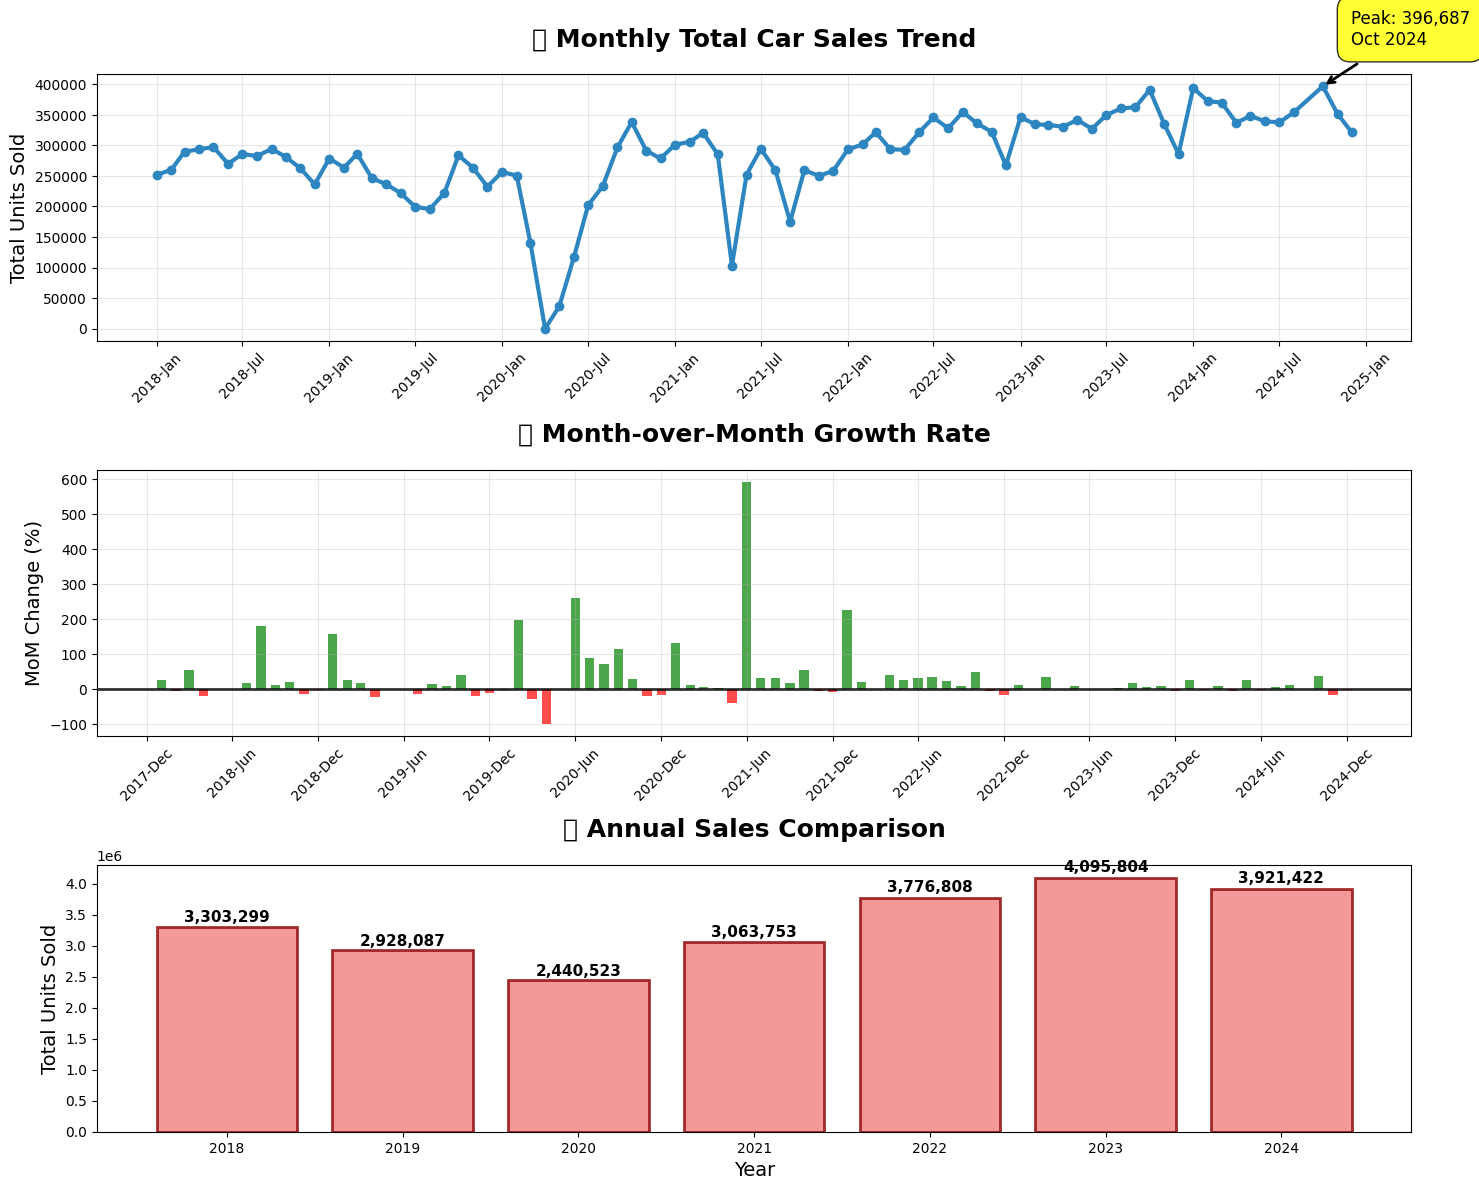

✅ Time series plots completed!


In [ ]:
def create_time_series_plots_fixed(df):
    """Create time series with proper date labels and error handling"""

    print("🔍 Debugging datetime creation...")
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Unique months: {sorted(df['Month'].unique())}")

    # Data preparation with proper date handling
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_num = {month: i+1 for i, month in enumerate(month_order)}

    # Group data first
    monthly_data = df.groupby(['Year', 'Month']).agg({
        'Units_Sold': 'sum',
        'MoM_Change': 'mean',
        'YoY_Change': 'mean'
    }).reset_index()

    print(f"Monthly data shape: {monthly_data.shape}")
    print(f"Sample data:")
    print(monthly_data.head())

    # Create month number mapping
    monthly_data['Month_Num'] = monthly_data['Month'].map(month_num)

    # Check for any missing month mappings
    missing_months = monthly_data[monthly_data['Month_Num'].isna()]
    if len(missing_months) > 0:
        print(f"⚠️ Warning: Found {len(missing_months)} rows with unmapped months:")
        print(missing_months[['Year', 'Month']].drop_duplicates())
        # Remove rows with missing month numbers
        monthly_data = monthly_data.dropna(subset=['Month_Num'])

    # Sort data
    monthly_data = monthly_data.sort_values(['Year', 'Month_Num'])

    # Create datetime column properly
    try:
        monthly_data['Date'] = pd.to_datetime({
            'year': monthly_data['Year'],
            'month': monthly_data['Month_Num'],
            'day': 1
        })
        print("✅ Successfully created datetime column")
    except Exception as e:
        print(f"❌ Error creating datetime: {e}")
        # Fallback: create a simple period label
        monthly_data['Date'] = monthly_data['Year'].astype(str) + '-' + monthly_data['Month']
        print("📅 Using period labels instead of datetime")

    # Create the plot
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    # Check if we have datetime or string dates
    if monthly_data['Date'].dtype == 'datetime64[ns]':
        # Use datetime plotting
        x_data = monthly_data['Date']
        date_formatting = True
    else:
        # Use index-based plotting with custom labels
        x_data = range(len(monthly_data))
        date_formatting = False

    # Monthly Sales Trend
    axes[0].plot(x_data, monthly_data['Units_Sold'],
                marker='o', linewidth=3, markersize=6, color='#2E86C1')
    axes[0].set_title('📈 Monthly Total Car Sales Trend', fontsize=18, fontweight='bold', pad=20)
    axes[0].set_ylabel('Total Units Sold', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    if date_formatting:
        # Format x-axis for datetime
        import matplotlib.dates as mdates
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    else:
        # Custom labels for every 6th point
        step = max(1, len(monthly_data) // 10)  # Show ~10 labels
        x_labels = [monthly_data['Date'].iloc[i] if i < len(monthly_data) else ''
                   for i in range(0, len(monthly_data), step)]
        x_positions = list(range(0, len(monthly_data), step))
        axes[0].set_xticks(x_positions)
        axes[0].set_xticklabels(x_labels, rotation=45, ha='right')

    # Highlight peak
    max_idx = monthly_data['Units_Sold'].idxmax()
    max_row = monthly_data.loc[max_idx]

    if date_formatting:
        peak_x = max_row['Date']
    else:
        peak_x = monthly_data.reset_index().loc[monthly_data.index.get_loc(max_idx), 'index']

    axes[0].annotate(f'Peak: {max_row["Units_Sold"]:,.0f}\n{max_row["Month"]} {max_row["Year"]}',
                    xy=(peak_x, max_row['Units_Sold']), xytext=(20, 30),
                    textcoords='offset points', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.8', fc='yellow', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=2))

    # MoM Growth Rate
    colors = ['red' if x < 0 else 'green' for x in monthly_data['MoM_Change']]

    if date_formatting:
        axes[1].bar(monthly_data['Date'], monthly_data['MoM_Change'],
                   color=colors, alpha=0.7, width=20)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    else:
        axes[1].bar(x_data, monthly_data['MoM_Change'],
                   color=colors, alpha=0.7)
        axes[1].set_xticks(x_positions)
        axes[1].set_xticklabels(x_labels, rotation=45, ha='right')

    axes[1].set_title('📊 Month-over-Month Growth Rate', fontsize=18, fontweight='bold', pad=20)
    axes[1].set_ylabel('MoM Change (%)', fontsize=14)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    axes[1].grid(True, alpha=0.3)

    # Yearly Comparison (this one works fine)
    yearly_data = df.groupby('Year')['Units_Sold'].sum().reset_index()
    bars = axes[2].bar(yearly_data['Year'], yearly_data['Units_Sold'],
                      color='lightcoral', edgecolor='darkred', linewidth=2, alpha=0.8)
    axes[2].set_title('📅 Annual Sales Comparison', fontsize=18, fontweight='bold', pad=20)
    axes[2].set_ylabel('Total Units Sold', fontsize=14)
    axes[2].set_xlabel('Year', fontsize=14)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

    print("✅ Time series plots completed!")

# Run the fixed version with better error handling
create_time_series_plots_fixed(results['cleaned_data'])